### Figures for the Dinkey Creek treatment effects on C balance paper
####Cornerstones of this paper are that:
* Severe fire events will be more prevalent in future climates
* Via management, we can reduce fire severity across the landscape
* The C consequences of not managing forests are two fold: increased C emission due to wildfire, and decreased NEE relative to the managed case -- ultimately reducing the potential for the land surface to take up and sequester C.



### Notebook  configuration and libraries used for plotting

In [364]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- For statistical tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import psturng

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats

# -------- Set working directory
wrkdir = 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\\'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Modifying some chloropleth code
Not implemented yet, but hexbinning up the Dinkey watershed would be really nice. Maybe save this for Osceola, given its larger area and discontinuous shape.

In [5]:
def __pysal_choro(values, scheme, k=5):
    """ Wrapper for choropleth schemes from PySAL for use with plot_dataframe

        Parameters
        ----------

        values
            Series to be plotted

        scheme
            pysal.esda.mapclassify classificatin scheme ['Equal_interval'|'Quantiles'|'Fisher_Jenks']

        k
            number of classes (2 <= k <=9)

        Returns
        -------

        values
            Series with values replaced with class identifier if PySAL is available, otherwise the original values are used
    """

    try:
        from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
        schemes = {}
        schemes['equal_interval'] = Equal_Interval
        schemes['quantiles'] = Quantiles
        schemes['fisher_jenks'] = Fisher_Jenks
        s0 = scheme
        scheme = scheme.lower()
        if scheme not in schemes:
            scheme = 'quantiles'
            print('Unrecognized scheme: ', s0)
            print('Using Quantiles instead')
        if k < 2 or k > 9:
            print('Invalid k: ', k)
            print('2<=k<=9, setting k=5 (default)')
            k = 5
        binning = schemes[scheme](values, k)
        values = binning.yb
    except ImportError:
        print('PySAL not installed, setting map to default')

    return binning

def plot_polygon(ax, poly, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)

from geopandas.plotting import (plot_linestring, plot_point, norm_cmap)


def plot_dataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, scheme=None,
                   k=5, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        categorical : bool (default False)
            If False, colormap will reflect numerical values of the
            column being plotted.  For non-numerical columns (or if
            column=None), this will be set to True.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot

        scheme : pysal.esda.mapclassify.Map_Classifier
            Choropleth classification schemes

        k   : int (default 5)
            Number of classes (ignored if scheme is None)


        Returns
        -------

        matplotlib axes instance
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from matplotlib import cm

    if column is None:
        return plot_series(s.geometry, colormap=colormap, alpha=alpha, axes=axes)
    else:
        if s[column].dtype is np.dtype('O'):
            categorical = True
        if categorical:
            if colormap is None:
                colormap = 'Set1'
            categories = list(set(s[column].values))
            categories.sort()
            valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
            values = [valuemap[k] for k in s[column]]
        else:
            values = s[column]
        if scheme is not None:
            binning = __pysal_choro(values, scheme, k=k)
            values = binning.yb
            # set categorical to True for creating the legend
            categorical = True
            binedges = [binning.yb.min()] + binning.bins.tolist()
            categories = ['{0:.2f} - {1:.2f}'.format(binedges[i], binedges[i+1]) for i in range(len(binedges)-1)]
        cmap = norm_cmap(values, colormap, Normalize, cm)
        if axes == None:
            fig = plt.gcf()
            fig.add_subplot(111, aspect='equal')
            ax = plt.gca()
        else:
            ax = axes
        for geom, value in zip(s.geometry, values):
            if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
                plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
            elif geom.type == 'LineString' or geom.type == 'MultiLineString':
                plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
            # TODO: color point geometries
            elif geom.type == 'Point':
                plot_point(ax, geom, color=cmap.to_rgba(value))
        if legend:
            if categorical:
                patches = []
                for value, cat in enumerate(categories):
                    patches.append(Line2D([0], [0], linestyle="none",
                                          marker="o", alpha=alpha,
                                          markersize=15, markerfacecolor=cmap.to_rgba(value)))
                ax.legend(patches, categories, numpoints=1, loc='best')
            else:
                # TODO: show a colorbar
                raise NotImplementedError

    plt.draw()
    return ax

### Area map
Cut and dry

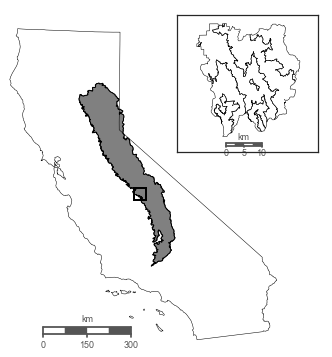

In [14]:


wrkDir = 'C:/Research/Dinkey_Creek/GIS_Data_And_Maps/'


shp = fiona.open(wrkDir + 'SierrasNad.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords2 = list(chain(ll, ur))
w, h = coords2[2] - coords2[0], coords2[3] - coords2[1]



fig1 = plt.figure(figsize = (6,6))
ax = fig1.add_subplot(111, frameon = False)

m = Basemap(llcrnrlon=-124,llcrnrlat=32.4,urcrnrlon=-111.5,urcrnrlat=42.5,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = ax)

m.drawmapscale(
    coords[0] + .5, coords[1] - 2,
    coords[0], coords[1],
    300.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1)

    
m.readshapefile(wrkDir + 'SierrasNad', 'Sierra',
    color='black', zorder=5)
sierraPatches = []

for info, shape in zip(m.Sierra_info, m.Sierra):
    if info['SECTION_NA'] == 'Sierra Nevada':
        sierraPatches.append( PolygonM(np.array(shape), True) )
ax.add_collection(PatchCollection(sierraPatches, 
          facecolor= 'grey', edgecolor='k', linewidths=1., zorder=2))

m.readshapefile(wrkDir + 'CaliforniaBoundary', 'Cali',
    color='black', zorder = 8)


axins = zoomed_inset_axes(ax, 12, loc=1)
m2 = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = axins)
m2.fillcontinents(color='white')
m2.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='black',ax = axins)

elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m2.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m2.Elevation_info[shape[0]].keys(),m2.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    axins.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1

m2.drawmapscale(
    coords2[0] + 0.15, coords2[1] - 0.02,
    coords2[0], coords2[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=2)

lbx2, lby2 = m(*m2(m2.xmin, m2.ymin, inverse= True))
ltx2, lty2 = m(*m2(m2.xmin, m2.ymax, inverse= True))
rtx2, rty2 = m(*m2(m2.xmax, m2.ymax, inverse= True))
rbx2, rby2 = m(*m2(m2.xmax, m2.ymin, inverse= True))

verts2 = [
    (lbx2, lby2), # left, bottom
    (ltx2, lty2), # left, top
    (rtx2, rty2), # right, top
    (rbx2, rby2), # right, bottom
    (lbx2, lby2), # ignored
    ]

codes2 = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts2, codes2)
patch = patches.PathPatch(path, facecolor = 'none', lw=2, zorder = 6)
ax.add_patch(patch)
plt.savefig('AreaMap.tif', dpi = 700)

### Three panel metadata figure
Look at what went into creating ecoregions, from elevation to soiltype, and display the ecoregions.

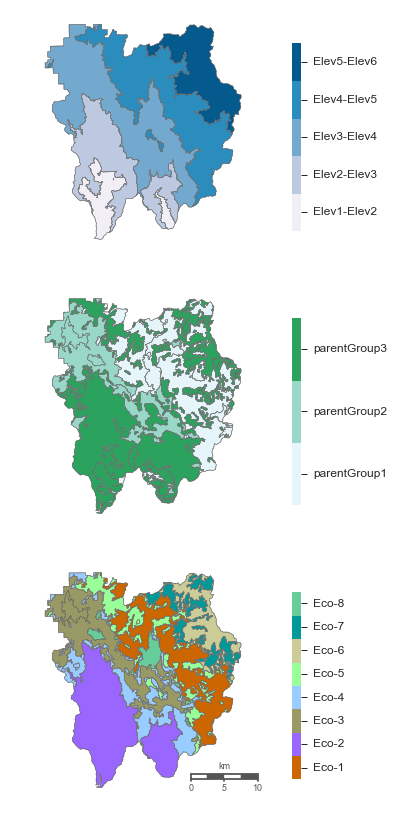

In [15]:
from matplotlib import colors

shp = fiona.open(wrkDir + 'DinkeyElevationShp.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (6,15))
ax = fig1.add_subplot(311, frameon = False)

Z = [[0,0],[0,0]]
levels = range(0,6)    #or whatever you need here
elevFC = ['#f1eef6','#bdc9e1','#74a9cf','#2b8cbe','#045a8d']
cmapELEV = colors.ListedColormap(elevFC)
CS3 = plt.contourf(Z, levels, cmap = cmapELEV)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5,3.5,4.5], shrink=.65)
cb.ax.set_yticklabels(['Elev1-Elev2', 'Elev2-Elev3', 'Elev3-Elev4','Elev4-Elev5','Elev5-Elev6'], fontsize = 12)
cb.ax.artists.remove(cb.outline) 


m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyElevationShp', 'Elevation',
    color='grey',
    zorder=2)

# set up a map dataframe
elev = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Elevation]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Elevation_info[shape[0]].keys(),m.Elevation_info[shape[0]].values()
    elev.append(values[1])
df_map['Elevation'] = elev
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
idx = 0 # Colormap iterator
for feature in np.unique(df_map.Elevation):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Elevation == feature], facecolor= elevFC[idx]))
    idx = idx + 1

ax = fig1.add_subplot(312, frameon = False)
Z = [[0,0],[0,0]]
levels = range(0,4)    
ParentGFC = ['#e5f5f9','#99d8c9','#2ca25f']
cmapPG = colors.ListedColormap(ParentGFC)
CS3 = plt.contourf(Z, levels, cmap = cmapPG)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5], shrink=.65)
cb.ax.set_yticklabels(['parentGroup1', 'parentGroup2', 'parentGroup3'], fontsize = 12)
cb.ax.artists.remove(cb.outline) 

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyGSSURGODissolveNAD83', 'PGroup',
    color='grey',
    zorder=2)

# set up a map dataframe
parentgroup = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.PGroup]})
for shape in enumerate(df_map['poly']):
    keys, values = m.PGroup_info[shape[0]].keys(),m.PGroup_info[shape[0]].values()
    parentgroup.append(values[3])
df_map['ParentGroup'] = parentgroup
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
idx = 0 # Colormap iterator
for feature in np.unique(df_map.ParentGroup):
    ax.add_collection(PatchCollection(df_map.patches[df_map.ParentGroup == feature], facecolor= ParentGFC[idx]))
    idx = idx + 1

shp = fiona.open(wrkDir + 'EcoregionsNAD83.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

ax = fig1.add_subplot(313, frameon = False)

Z = [[0,0],[0,0]]
levels = range(0,9)    
EcoregionFC =  ['#cc6600', '#9966ff','#999966',
                           '#99ccff', '#99ff99', '#cccc99', 
                           '#009999', '#66cc99']
cmapEco = colors.ListedColormap(EcoregionFC)

CS3 = plt.contourf(Z, levels, cmap = cmapEco)
plt.cla()                   #deletes the dummy plot
cb = plt.colorbar(CS3,ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], shrink=.65)
cb.ax.set_yticklabels(['Eco-1', 'Eco-2', 'Eco-3','Eco-4',
                       'Eco-5','Eco-6','Eco-7','Eco-8'], 
                      fontsize = 12)
cb.ax.artists.remove(cb.outline) 

m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'EcoregionsNAD83', 'Ecoregion',
    color='grey',
    zorder=2)

# set up a map dataframe
ecoregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.Ecoregion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.Ecoregion_info[shape[0]].keys(),m.Ecoregion_info[shape[0]].values()
    ecoregion.append(values[5])
df_map['Ecoregion'] = ecoregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ecocolors = ['#cc6600', '#9966ff','#999966',
                           '#99ccff', '#99ff99', '#cccc99', 
                           '#009999', '#66cc99']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.Ecoregion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.Ecoregion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)


plt.subplots_adjust(hspace = -.05)
plt.savefig('ThreePanel_draft.tif')
plt.show()


### Fire history and size distribution
One figure to sum up the data that went into generating our historic fire size and frequency parameterization

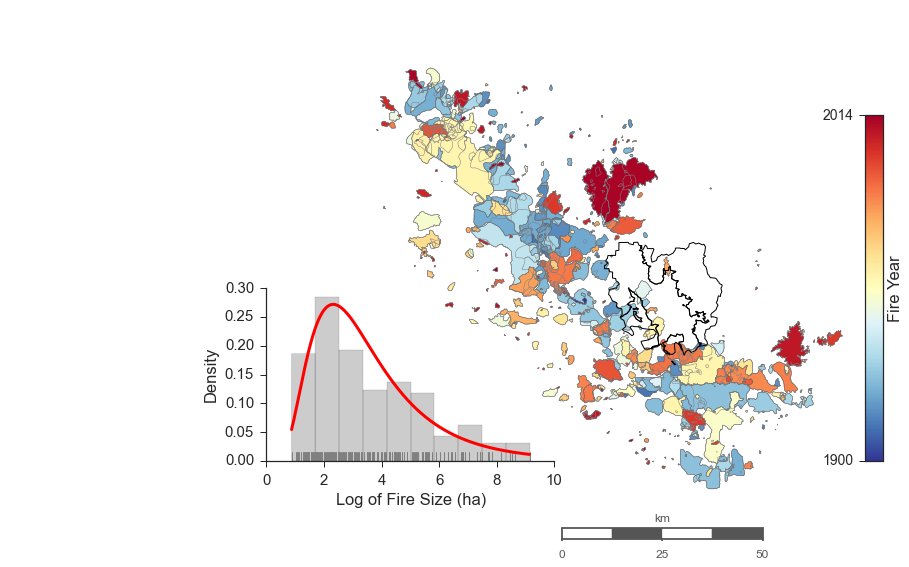

In [16]:
from scipy import stats

shp = fiona.open(wrkDir + 'DinkeyMetroFires.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig3, (ax) = plt.subplots(1,1, figsize =(16,16))

m = Basemap(llcrnrlon=-121,llcrnrlat=36.5,urcrnrlon=-118.5,urcrnrlat=37.70,
             resolution='i', projection='aea', lat_0 = 37.62, lon_0 = -119.51)
    
m.readshapefile(wrkDir + 'DinkeyMetroFires', 'FireRegion',
    color='grey',
    zorder=2)

m.readshapefile(wrkDir + 'DinkeyFireRegions_ll', 'FireRegionD',
    color='black', linewidth = 1,
    zorder=2)


# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[2])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireregion = map(int, fireregion)
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireregion))
p.set_clim([np.ma.min(fireregion),np.ma.max(fireregion)])
ax.add_collection(p)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.8, coords[1] - 0.1,
    coords[0], coords[1],
    50., fontsize = 12,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

cbaxes = fig3.add_axes([0.87, 0.35, 0.015, 0.3]) 
cbar = plt.colorbar(p, cax = cbaxes, ticks = [1900,2014])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Fire Year')
#cbar = plt.colorbar(p, shrink = 0.3, ticks=[1900, 2014])

axsub = fig3.add_axes([0.35, 0.35, 0.25, 0.15], zorder = 0)

metadata = pd.read_csv(wrkDir + 'DinkeyMetroFires_metadata.txt')
# Data driven approach:
metadata['HECTARES'] = metadata.GIS_ACRES * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()
metadata = metadata[metadata.YEAR_ > 1983]
# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data
#n, bins, patches = plt.hist(rvs, bins=25, normed=True) # Plot histogram

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
x = np.linspace(rvs.min(), rvs.max(), num=400)
g = sns.distplot(rvs, kde=False, rug=True, ax = axsub, 
                 color = 'gray', norm_hist = True);
axsub.plot(x, stats.lognorm.pdf(x, shape, 
            loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
axsub.set_xlabel('Log of Fire Size (ha)')
axsub.set_ylabel('Density')
sns.despine()
axsub.patch.set_facecolor('none')
ax.axis('off')

plt.savefig('FireSize_Dist.tif', dpi = 700)

### Fire region and fireweather distributions
Illustrate the fire regions and draw distributions for the inputs to the DFFS in landis, showing primarily the difference in fire weather between historic and severe.

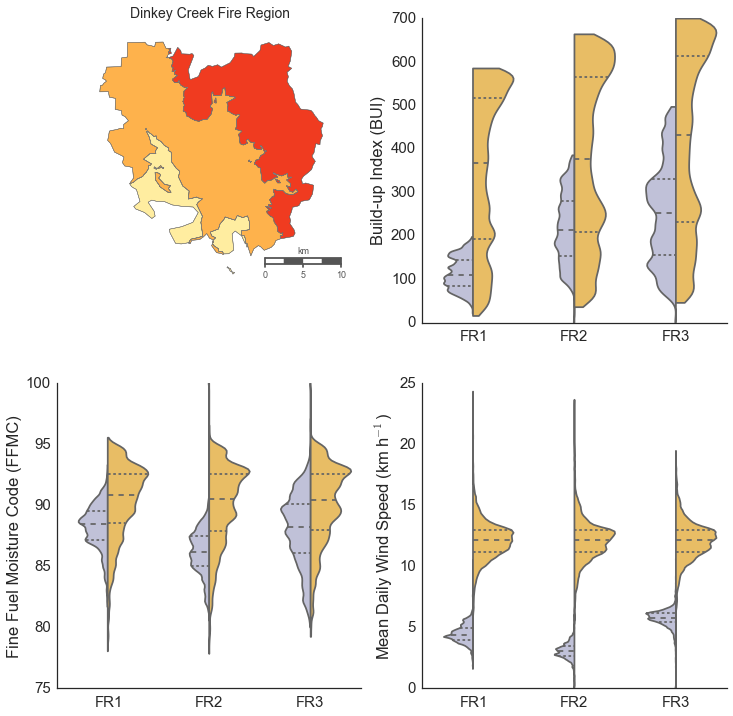

In [20]:
shp = fiona.open(wrkDir + 'DinkeyFireRegions_ll.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

fig1 = plt.figure(figsize = (12,12))
ax = fig1.add_subplot(221, frameon = False)
m = Basemap(llcrnrlon=-119.4,llcrnrlat=36.85,urcrnrlon=-118.95,urcrnrlat=37.2,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3)
    
m.readshapefile(wrkDir + 'DinkeyFireRegions_ll', 'FireRegion',
    color='grey',
    zorder=2)

# set up a map dataframe
fireregion = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.FireRegion]})
for shape in enumerate(df_map['poly']):
    keys, values = m.FireRegion_info[shape[0]].keys(),m.FireRegion_info[shape[0]].values()
    fireregion.append(values[3])
df_map['FireRegion'] = fireregion
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

# Paint the features
# Colormap for elevation
EcoregionFC = ['#ffeda0', '#feb24c', '#f03b20']

idx = 0 # Colormap iterator
for feature in np.unique(df_map.FireRegion):
    ax.add_collection(PatchCollection(df_map.patches[df_map.FireRegion == feature], facecolor= EcoregionFC[idx]))
    idx = idx + 1
ax.set_title('Dinkey Creek Fire Region', fontsize = 14)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.3, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
#plt.show()


FW_His = pd.read_csv('Z:\DinkeyFW_Historic.csv')
FW_Sev = pd.read_csv('Z:\DinkeySevereFW.csv')

FW_His['FW_TYPE'] = 'Historic'
FW_Sev['FW_TYPE'] = 'Severe'
allFW = pd.concat([FW_His, FW_Sev])

ax = fig1.add_subplot(222)

FWSevColors = ["#bcbddc","#fec44f"]
FWSev = sns.color_palette(FWSevColors)

fwDistributions = sns.violinplot(x="Ecoregion", y="BUI", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1, ax = ax)
ax.set_ylabel('Build-up Index (BUI)')
ax.set_xlabel('')

ax = gca()
ax.legend_.remove()
#ax.set_ylim([0,800])
sns.despine()

ax = fig1.add_subplot(223)
fwDistributions = sns.violinplot(x="Ecoregion", y="FFMC", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1, ax = ax)
ax.set_ylabel('Fine Fuel Moisture Code (FFMC)')
ax.set_xlabel('')

ax = gca()
ax.legend_.remove()

sns.despine()
sns.set_style('white')

ax = fig1.add_subplot(224)
fwDistributions = sns.violinplot(x="Ecoregion", y="WSV", hue="FW_TYPE",
                     data=allFW, palette = FWSev,
                     split=True, scale = 'count', 
                     inner="quartile", cut = 0, bw = 0.1,
                                 ax = ax)
ax.set_ylabel('Mean Daily Wind Speed (km h$^{-1}$)')
ax.set_xlabel('')
ax = gca()
ax.legend_.remove()
#ax.set_ylim([0,25])


sns.despine()
plt.savefig('FireRegionAndWeather.tif')

### Process the LANDIS output
and create data frames by treatment, for the sake of plotting down the road.

In [345]:
simNamesV2 = ['NoMgmtHistoricFireLowP','NoMgmtSevereFireLowP',
            'ThinHistoric_FV2', 'ThinSevere_FV2',
            'ThinRxHistoric_FV2','ThinRxSevere_FV2']

def centOutputGen(dataDir, simname):
    wkDir_reps =  dataDir + simname + '/'
    centFileName = 'Century-succession-log.csv'
    centFileNameM = 'Century-succession-monthly-log.csv'
    sppBioName = 'spp-biomass-log.csv'

    repnames = next(os.walk(wkDir_reps))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        wkDir_data = wkDir_reps + 'replicate' + repnum + '/'
        cent = pd.read_csv(wkDir_data + centFileName)
        cent['rep'] = int(repnum)
        centM = pd.read_csv(wkDir_data + centFileNameM)
        centM['rep'] = int(repnum)
        sppBio = pd.read_csv(wkDir_data + sppBioName)
        sppBio['rep'] = int(repnum)

        if idx == 0:
            centTot = cent
            centTotM = centM
            sppBioTot = sppBio

        else:
            centTot = pd.concat((centTot, cent))
            centTotM = pd.concat((centTotM, centM))
            sppBioTot = pd.concat((sppBioTot, sppBio))

        idx = idx + 1
    return centTot, centTotM, sppBioTot


def genCentWeightedMeansDF(aggregatedAnnualCentFile, simName):
    simCentDF = aggregatedAnnualCentFile
    # ------- Create new vars in Cent file and handle unit conversion ------- #
    simCentDF['TEC'] = (simCentDF['SOMTC'] + simCentDF['AGB']* 0.5 ) * 0.01 # Add total ecosystem carbon, Mg/ha
    simCentDF['AGBc'] = simCentDF['AGB']* 0.5 * 0.01 # Convert AGB from g /m^2 biomass to Mg/ha C
    simCentDF['NEEC'] = simCentDF['NEEC'] * -1 * 0.01 # Convert NEE sign convention 
    simCentDF['NECB'] = simCentDF['NEEC'] - (simCentDF['FireCEfflux'] * 0.01)
    activeArea = simCentDF.NumSites.unique().sum() # Calculate total sites in the simulation

    # ------- Generate mean and std of weighted ecoregion data ------- #
    simCentDF['TECw'] = simCentDF.TEC * (simCentDF.NumSites / activeArea)
    simCentDF['AGBw'] = simCentDF.AGBc * (simCentDF.NumSites / activeArea)
    simCentDF['NEECw'] = simCentDF.NEEC * (simCentDF.NumSites / activeArea)
    
    # Convert the fire efflux from g/m2 to Mg/ha (already in units of C), and 
    # produce the ecoregion weighted per hectare value
    simCentDF['FireCEffluxw'] = simCentDF.FireCEfflux * 0.01 * (simCentDF.NumSites / activeArea)
    simCentDF['NECBw'] = simCentDF['NEECw'] - simCentDF['FireCEffluxw']
    
    naiveMean = simCentDF.groupby(['EcoregionName','Time']).mean()
    naiveStd = simCentDF.groupby(['EcoregionName','Time']).std()
    
    # Generate a dataframe for that we can leverage when we want to ask questions
    # about the cumulative nature of some century variable, by replicate.
    naiveSum= simCentDF.groupby(['rep']).sum()

    naiveMean['NEECw_std'] = naiveStd.NEEC * (naiveMean.NumSites / activeArea) # 
    naiveMean['AGBw_std'] = naiveStd.AGBc * (naiveMean.NumSites / activeArea)
    naiveMean['TECw_std'] = naiveStd.TEC * (naiveMean.NumSites / activeArea)
    naiveMean['FireCEffluxw_std'] = naiveStd.FireCEfflux * (naiveMean.NumSites / activeArea)
    naiveMean['NECBw_std'] = naiveStd.NECBw * (naiveMean.NumSites / activeArea)
    resetMean = naiveMean.reset_index()
    resetSum = naiveSum.reset_index()
    
    # ------- Generate region-wide weighted mean of all ecoregions ------ #
    weightedMean = resetMean.groupby('Time').sum()  
    index = pd.date_range('2000-1-1', periods=len(weightedMean), freq='1A')
    weightedMean.index = index
    weightedMean[weightedMean.NEECw == 0] = np.nan
    weightedMean['Sim'] = simName
    resetSum['Sim'] = simName
    simCentDF['Sim'] = simName

    return weightedMean, simCentDF, resetSum

def plotSimulationCarbon(weightedMeansDF):
    weightedMean = weightedMeansDF
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
    plt.subplots_adjust(wspace = 0.3)
    simidx = 0
    simColors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c', 'black']
    for sim in np.unique(weightedMean.Sim):
        print sim
        simMean = weightedMean[weightedMean.Sim == sim]
        simMean.AGBw.plot(ax = ax1, color = simColors[simidx])
        simMean.TECw.plot(ax = ax2, color = simColors[simidx])
        simMean.NEECw.plot(ax = ax3, color = simColors[simidx])
        simMean.FireCEffluxw.cumsum().plot(ax = ax4, color = simColors[simidx])
        simMean.NECBwHA = simMean.NECBw * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA_stdHA = simMean.NECBw_std * 0.01 # Mg/ha for cumulative curves
        simMean.NECBwHA.plot(ax = ax6, color = simColors[simidx])
        

        ax1.fill_between(simMean.index, 
                         simMean.AGBw+simMean.AGBw_std, 
                         simMean.AGBw-simMean.AGBw_std, 
                         alpha = 0.2, color = simColors[simidx])

        ax2.fill_between(simMean.index, 
                         simMean.TECw+simMean.TECw_std, 
                         simMean.TECw-simMean.TECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        ax3.fill_between(simMean.index, 
                         simMean.NEECw+simMean.NEECw_std, 
                         simMean.NEECw-simMean.NEECw_std, 
                         alpha = 0.2, color = simColors[simidx])
        
        #Replaced the cumulatiev curves with boxplots of cumulative C emissions from fire
        ax4.fill_between(simMean.index, 
                         simMean.FireCEffluxw.cumsum()+simMean.FireCEffluxw_std, 0,
                         alpha = 0.2, color = simColors[simidx])
        
        ax6.fill_between(simMean.index, 
                         simMean.NECBwHA+simMean.NECBwHA_stdHA, 
                         simMean.NECBwHA-simMean.NECBwHA_stdHA, 
                         alpha = 0.2, color = simColors[simidx])
        
        simidx = simidx + 1

    # ------ Aesthetics ------ #
    ax1.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax2.set_ylabel('TEC (Mg ha $^{-1}$)')
    ax3.set_ylabel('NEE (gC m$^{-2}$)')
    ax4.set_ylabel('Cumulative Fire Efflux gC m$^{-2}$)')
    ax5.set_ylabel('AGB (MgC ha $^{-1}$)')
    ax6.set_ylabel('Cumulative NECB MgC ha$^{-1}$)')
    
    ax2.set_xlabel('Simulation Year')
    ax5.set_xlabel('Model Simulation')
    
    lastTen = weightedMean[weightedMean.index.year >= 2090]
    #g = sns.boxplot(x="Sim", y=weightedMean.FireCEffluxw,
    #              data=weightedMean, ax = ax4, palette=simColors)
    ax4.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    #ax4.set_ylim([0,1000])

    g = sns.boxplot(x="Sim", y="AGBw",
                  data=lastTen, ax = ax5, palette=simColors)
    ax5.set_xticklabels(lastTen.Sim.unique(),rotation = 45)
    
    sns.despine()
    sns.set_style('white')
    sns.set_context('notebook', font_scale=1.5)

    ax1.legend(np.unique(weightedMean.Sim), loc = 'lower right')
    
prodDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'

simCentH, simCent_mH, sppbioHis = centOutputGen(prodDir, simNamesV2[0])
simCentS, simCent_mS, sppbioSev = centOutputGen(prodDir, simNamesV2[1])
simCentHT, simCent_mHT, sppbioHisT = centOutputGen(prodDir, simNamesV2[2])
simCentST, simCent_mST, sppbioSevT = centOutputGen(prodDir, simNamesV2[3])
simCentHTRx, simCent_mHTRx, sppbioHisTRx = centOutputGen(prodDir, simNamesV2[4])
simCentSTRx, simCent_mSTRx, sppbioSevTRx = centOutputGen(prodDir, simNamesV2[5])


weightedHWF, simCentCHWF, summedHWF = genCentWeightedMeansDF(simCentH, 'No Mgmt HWF')
weightedSWF, simCentCSWF, summedSWF = genCentWeightedMeansDF(simCentS, 'No Mgmt SWF')
weightedHWFT, simCentCHWFT, summedHWFT = genCentWeightedMeansDF(simCentHT, 'Thinning HWF')
weightedSWFT, simCentCSWFT, summedSWFT = genCentWeightedMeansDF(simCentST, 'Thinning SWF')
weightedHWFTRx, simCentCHWFTRx, summedHWFTRx = genCentWeightedMeansDF(simCentHTRx, 'ThinningRx HWF')
weightedSWFTRx, simCentCSWFTRx, summedSWFTRx = genCentWeightedMeansDF(simCentSTRx, 'ThinningRx SWF')

totSims = pd.concat([weightedHWF, weightedSWF, weightedHWFT, weightedSWFT,weightedHWFTRx,weightedSWFTRx])
totSimsNW = pd.concat([simCentCHWF, simCentCSWF, simCentCHWFT, simCentCSWFT,simCentCHWFTRx,simCentCSWFTRx])
totSums = pd.concat([summedHWF, summedSWF, summedHWFT, summedSWFT,summedHWFTRx,summedSWFTRx])

Historic = [np.unique(totSims.Sim)[0],np.unique(totSims.Sim)[2],np.unique(totSims.Sim)[4]]
Severe = [np.unique(totSims.Sim)[1],np.unique(totSims.Sim)[3],np.unique(totSims.Sim)[5]]
simsSevere = totSims[(totSims.Sim == Severe[0]) | (totSims.Sim == Severe[1]) | (totSims.Sim == Severe[2])]
simsHistoric = totSims[(totSims.Sim == Historic[0]) | (totSims.Sim == Historic[1]) | (totSims.Sim == Historic[2])]

#### We need a figure (or just the data) to show our AGB parameterization relative to FIA inputs
Since all IC and Century climate data are the same, all spin-up biomass maps look identical. I'll just grab one and use it to generate our biomass distribution. Then we have to read in the FIA biomass for the FIA plots within the Dinkey Creek area -- here, I calculated AGB using Jenkins allometries.

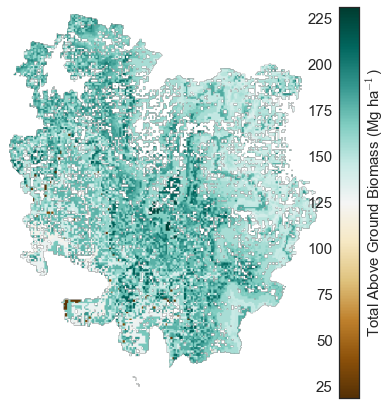

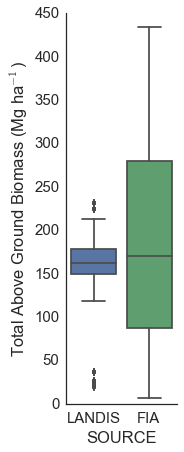

In [194]:
# Read in the raster
biomap = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP/replicate1/bioMAP/bio-TotalBiomass-0.img'
src_ds = gdal.Open( biomap )
bioarray = src_ds.ReadAsArray()
bioarray = bioarray.astype('float')
bioarray[bioarray == 0] = np.nan
bioarray = bioarray * 0.01
masked_bio = np.ma.array (bioarray, mask=(np.isnan(bioarray)))  

# Create the figure and show the image
f, (ax) = plt.subplots(1,1, figsize =(7,7))
axmap = ax.imshow(bioarray, cmap = 'BrBG')

# Color bar
cbar = f.colorbar(axmap)
cbar.set_label('Total Above Ground Biomass (Mg ha$^{-1}$)', fontsize = 15)

# Axis label formatting, and seaborn despining
ax.set_yticklabels('')
ax.set_xticklabels('')
sns.despine(left=True, bottom=True)
sns.set_style('white')

# Create a dataframe from the raster, and join it to previously worked up FIA data
initBio = pd.DataFrame(dict(Biomass = bioarray.ravel(), SOURCE = 'LANDIS'))
fiaBio = pd.read_csv('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/JenkinsDinkeyBiomass.csv')
fiaBio.Biomass = fiaBio.Biomass * 0.01
validateBio = pd.concat([initBio, fiaBio])

# Boxplot the FIA and LANDIS initial biomass data
f, (ax) = plt.subplots(1,1, figsize =(2,7))
sns.boxplot(y = 'Biomass', x = 'SOURCE', data = validateBio.dropna())
ax.set_ylabel('Total Above Ground Biomass (Mg ha$^{-1}$)')
sns.despine()

### Above ground carbon and total ecosystem carbon
Heres half the story -- C trends by treatment. 

No Mgmt HWF
Thinning HWF
ThinningRx HWF
No Mgmt HWF
Thinning HWF
ThinningRx HWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt SWF
Thinning SWF
ThinningRx SWF
No Mgmt HWF
Thinning HWF
ThinningRx HWF


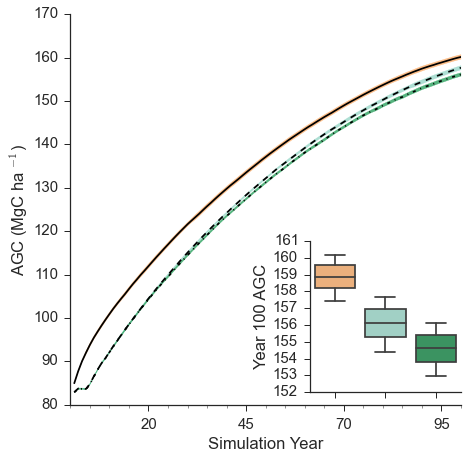

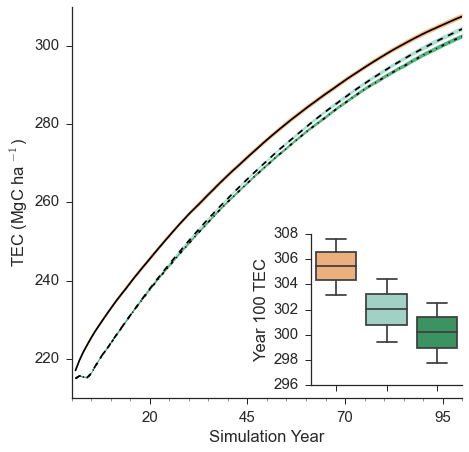

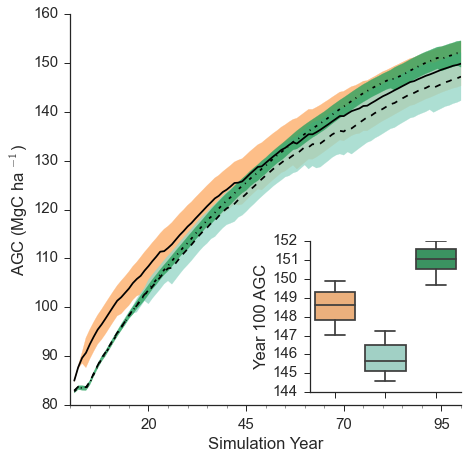

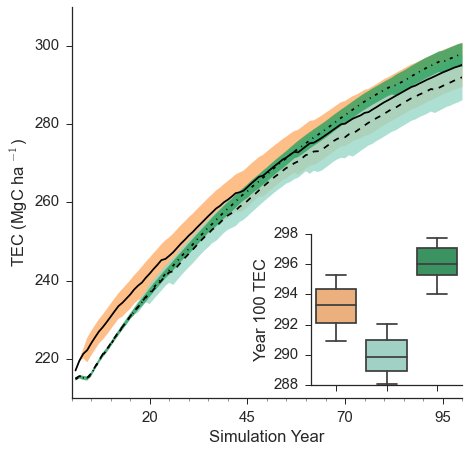

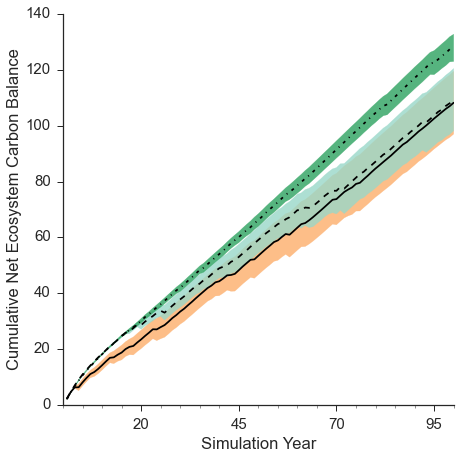

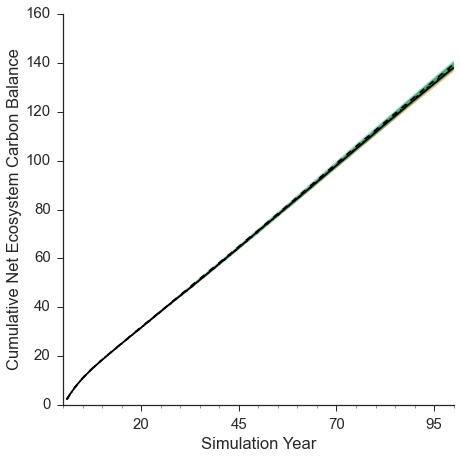

In [230]:
sns.set_context('notebook', font_scale=1.5)

### HISTORIC FIRE WEATHER AGB -------------------------------

f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.AGBw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                 simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])

left, bottom, width, height = [0.6, 0.15, 0.3, 0.3]
axsub = f.add_axes([left, bottom, width, height])

lastTen = simsHistoric[simsHistoric.index.year >= 2090]
g = sns.boxplot(x="Sim", y="AGBw",
              data=lastTen, ax = axsub, palette=simColors)
axsub.set_xticklabels([''])
axsub.set_xlabel('')
axsub.set_ylabel('Year 100 AGC')
#axsub.set_yticks([142, 146, 150, 154])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('AGC (MgC ha $^{-1}$)')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_AGC_insetBox.tif')


### HISTORIC FIRE WEATHER TEC -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.TECw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.TECw+3*simMean.TECw_std/np.sqrt(50), 
                 simMean.TECw-3*simMean.TECw_std/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])


left, bottom, width, height = [0.6, 0.15, 0.3, 0.3]
axsub = f.add_axes([left, bottom, width, height])

lastTen = simsHistoric[simsHistoric.index.year >= 2090]
g = sns.boxplot(x="Sim", y="TECw",
              data=lastTen, ax = axsub, palette=simColors)
axsub.set_xticklabels([''])
axsub.set_xlabel('')
axsub.set_ylabel('Year 100 TEC')
#axsub.set_yticks([286, 290, 294, 298])
ax.set_ylim([210, 310])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('TEC (MgC ha $^{-1}$)')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_TEC_insetBox.tif')


### SEVERE FIRE WEATHER AGB -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.AGBw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                 simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])


left, bottom, width, height = [0.6, 0.15, 0.3, 0.3]
axsub = f.add_axes([left, bottom, width, height])

lastTen = simsSevere[simsSevere.index.year >= 2090]
g = sns.boxplot(x="Sim", y="AGBw",
              data=lastTen, ax = axsub, palette=simColors)
axsub.set_xticklabels([''])
axsub.set_xlabel('')
axsub.set_ylabel('Year 100 AGC')
#axsub.set_yticks([142, 146, 150, 154])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('AGC (MgC ha $^{-1}$)')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_AGC_insetBox.tif')


### SEVERE FIRE WEATHER TEC -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.TECw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.TECw+3*simMean.TECw_std/np.sqrt(50), 
                 simMean.TECw-3*simMean.TECw_std/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])


left, bottom, width, height = [0.6, 0.15, 0.3, 0.3]
axsub = f.add_axes([left, bottom, width, height])

lastTen = simsSevere[simsSevere.index.year >= 2090]
g = sns.boxplot(x="Sim", y="TECw",
              data=lastTen, ax = axsub, palette=simColors)
axsub.set_xticklabels([''])
axsub.set_xlabel('')
axsub.set_ylabel('Year 100 TEC')
#axsub.set_yticks([286, 290, 294, 298])
ax.set_ylim([210, 310])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('TEC (MgC ha $^{-1}$)')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_TEC_insetBox.tif')


### SEVERE FIRE WEATHER NECB -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Severe:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.NECBw.cumsum().plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.NECBw.cumsum()+3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 simMean.NECBw.cumsum()-3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1
    ax.set_xticklabels([20,45,70,95])


ax.set_xlabel('Simulation Year')
ax.set_ylabel('Cumulative Net Ecosystem Carbon Balance')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Severe_NECB.tif')



f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
simColors = ['#fdae6b','#99d8c9','#2ca25f']
simStyles = ['-','--','-.']
for sim in Historic:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.NECBw.cumsum().plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.NECBw.cumsum()+3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 simMean.NECBw.cumsum()-3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 alpha = 0.8, color = simColors[simidx])
    simidx = simidx + 1
    ax.set_xticklabels([20,45,70,95])

ax.set_xlabel('Simulation Year')
ax.set_ylabel('Cumulative Net Ecosystem Carbon Balance')
axsub.legend(loc = 2)

sns.despine()
sns.set_style('ticks')
plt.savefig('Historic_NECB.tif')


### Adding significance tests for year 100 C stocks
While the last decade of the simulation shows some differences in C stocks with treatment and fire weather, we need to test the actual end of simulation for differences. We need to pull out the end of simulation C values, then run a test on them. This is oddly a pain, since I never preserved any century output by replicate, I just calculated means and variances to populate the output dataframe. I went through the genWeightedCent function to append the simulation name to the fully aggregated century dataframe, and added a bit of code to output a version of the data that had not been aggregated by replicate. Takes a little bit of tape for the time being but heres the solution

     Multiple Comparison of Means - Tukey HSD,FWER=0.01    
   group1        group2     meandiff  lower   upper  reject
-----------------------------------------------------------
No Mgmt HWF   Thinning HWF   -2.613  -2.8904 -2.3355  True 
No Mgmt HWF  ThinningRx HWF -4.1401  -4.4176 -3.8627  True 
Thinning HWF ThinningRx HWF -1.5271  -1.8046 -1.2497  True 
-----------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD,FWER=0.01    
   group1        group2     meandiff  lower   upper  reject
-----------------------------------------------------------
No Mgmt SWF   Thinning SWF  -2.8038  -5.0362 -0.5714  True 
No Mgmt SWF  ThinningRx SWF  2.2331   0.0007  4.4655  True 
Thinning SWF ThinningRx SWF  5.0369   2.8045  7.2693  True 
-----------------------------------------------------------


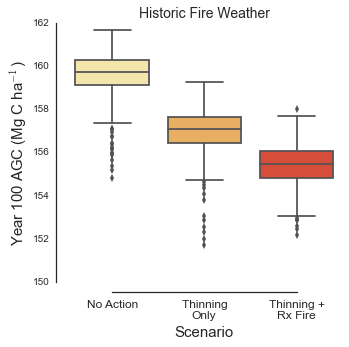

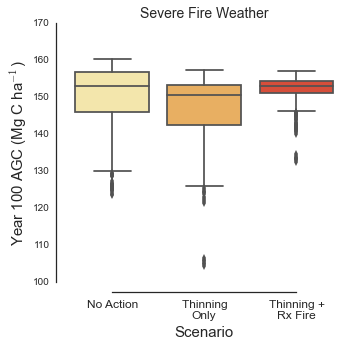

In [405]:
# Grab the dataframe without any means or sums by rep. Note, it also 
# doesn't have any sums over ecoregions, but it does
# have the apropriate columns to do so (the weighted columns... )
# We need to take a sum by ecoregion, but preserve simulation name, time, and rep
centReps = totSimsNW.groupby(['Time','Sim','rep']).sum().reset_index()

# Gut check, this looks similar to the output above -- good thing.
# Now we need to extract the year 100 values for our AGBw column. 
# Note here we don't have a timestamp index either. No bother, we will
# use the 'Time' column rather than index.year.
centReps100 = centReps[centReps.Time > 94]

# Separate this dataframe into historic and severe simulations
HWF = centReps100[(centReps100.Sim == 'No Mgmt HWF') | \
                  (centReps100.Sim == 'Thinning HWF') | \
                  (centReps100.Sim == 'ThinningRx HWF')]

SWF = centReps100[(centReps100.Sim == 'No Mgmt SWF') | \
                  (centReps100.Sim == 'Thinning SWF') | \
                  (centReps100.Sim == 'ThinningRx SWF')]

# Make a couple quick plots to visualize the differences
f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'AGBw', data = HWF, 
                  palette=EcoregionFC)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Year 100 AGC (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('AGB_year100_Historic_bar.tif')

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'AGBw', data = SWF, 
                  palette=EcoregionFC)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Year 100 AGC (Mg C ha$^{-1}$)', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('AGB_year100_Severe_bar.tif')

print pairwise_tukeyhsd(HWF.dropna()['AGBw'], HWF.dropna()['Sim'], alpha=0.005)
print pairwise_tukeyhsd(SWF.dropna()['AGBw'], SWF.dropna()['Sim'], alpha=0.005)

# The result shows in the historic fire weather condition, all treatments are significantly different
# from one another, p < 0.05. In the severe fire weather condition, the only significant difference is
# the thin only from the thin and burn (p < 0.05).

### Code to import and stack rasters to create maps of ... stuff


In [23]:
def severityStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
            sevmap = 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)
            
    return rasterlist

def NEEStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/century/'
            sevmap = 'nee-' + str(int(time)) + '.gis'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)
            
    return rasterlist


def severityGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    rasterAdj = rasterStack - 2
    rasterAdj[rasterAdj < 0] = np.nan
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)
    return meanSev, varSev

def NEEGen(rasterList):
    rasterStack = np.dstack(rasterList)
    rasterStack[rasterStack == 0] = np.nan
    rasterAdj = rasterStack - 1000
    cumNEE = np.nansum(rasterAdj, axis = 2)
    varNEE = np.nanvar(rasterAdj, axis = 2)
    return cumNEE, varNEE

### Generate the mean and CV raster stacks for fire severity

In [24]:
dataDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
sevMapsLowP = []
sevVarMapsLowP = []

for sim in simNamesV2:
    print dataDir + sim
    sevrasters = severityStack(dataDir + sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(sevVarmap)


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


### Plot the fire severity and CV rasters

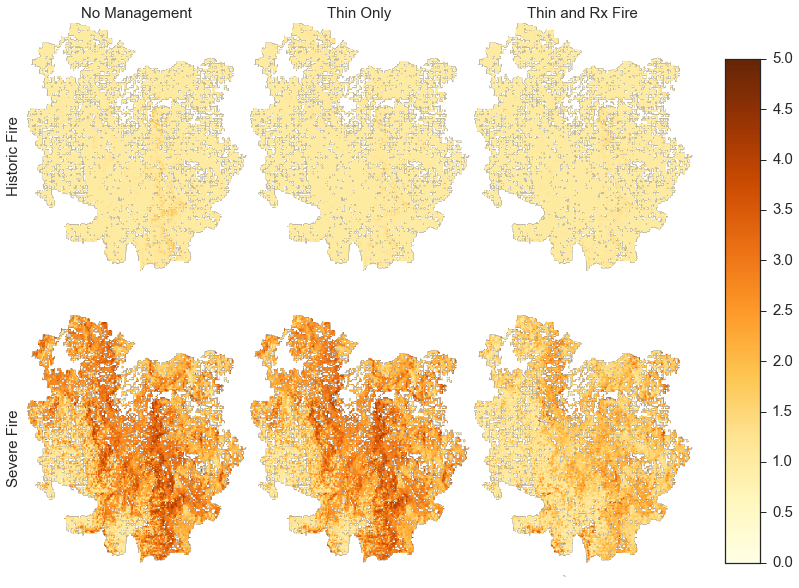

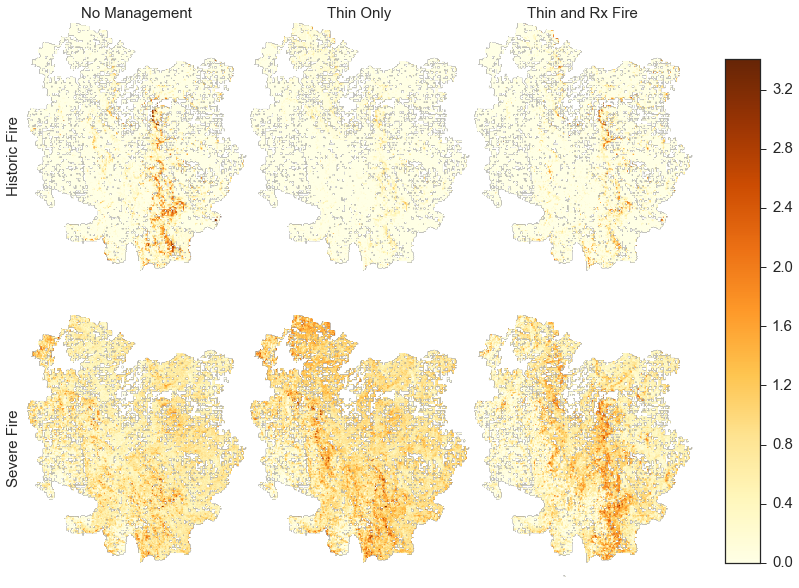

In [25]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax2.imshow(sevMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax3.imshow(sevMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax4.imshow(sevMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax5.imshow(sevMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax6.imshow(sevMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
plt.savefig('FireSeverity_Dinkey.tif')

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevVarMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr')
ax2.imshow(sevVarMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr')
ax3.imshow(sevVarMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr')
ax4.imshow(sevVarMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr')
ax5.imshow(sevVarMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr')
cbarmap = ax6.imshow(sevVarMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr')
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
sns.set_style('white')

plt.savefig('FireSeverityCV_Dinkey.tif')


### Generate the NEE and CV of NEE rasters

In [26]:
neeMapsLowP = []
neeVarMapsLowP = []

for sim in simNamesV2:
    print dataDir + sim
    neerasters = NEEStack(dataDir + sim, 100)
    neeMap, neeVarMap = NEEGen(neerasters)
    neemap = {sim : neeMap}
    neevarmap = {sim : neeVarMap}

    neeMapsLowP.append(neemap)
    neeVarMapsLowP.append(neevarmap)

neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] == 0] = np.nan
neeMapsLowP[1][simNamesV2[1]][neeMapsLowP[1][simNamesV2[1]] == 0] = np.nan
neeMapsLowP[2][simNamesV2[2]][neeMapsLowP[2][simNamesV2[2]] == 0] = np.nan
neeMapsLowP[3][simNamesV2[3]][neeMapsLowP[3][simNamesV2[3]] == 0] = np.nan
neeMapsLowP[4][simNamesV2[4]][neeMapsLowP[4][simNamesV2[4]] == 0] = np.nan
neeMapsLowP[5][simNamesV2[5]][neeMapsLowP[5][simNamesV2[5]] == 0] = np.nan

Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxHistoric_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


#### Convert the NEE data to appropriate units, and generally clean things up.
Chunking the data up into dataframes here just makes subsetting or faceting easier if we want to look at the treatment or weather differences etc. I also change the sign convention here toward a land centric one (rather than an atmosphere centric one). 

In [27]:
len(neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] > 0])
len(neeMapsLowP[0][simNamesV2[0]][neeMapsLowP[0][simNamesV2[0]] < 0])
meanAnnualNEEs1 = pd.DataFrame(dict(NEE = neeMapsLowP[0][simNamesV2[0]].ravel()*0.01 / ((50 * 100)) , 
                                  TRTMNT = 'NoAction', WEATHER = 'Historic'))

meanAnnualNEEs2 = pd.DataFrame(dict(NEE = neeMapsLowP[2][simNamesV2[2]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin Only', WEATHER = 'Historic'))

meanAnnualNEEs3 = pd.DataFrame(dict(NEE = neeMapsLowP[4][simNamesV2[4]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin + RxFire', WEATHER = 'Historic'))

meanAnnualNEEs4 = pd.DataFrame(dict(NEE = neeMapsLowP[1][simNamesV2[1]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'NoAction', WEATHER = 'Severe'))

meanAnnualNEEs5 = pd.DataFrame(dict(NEE = neeMapsLowP[3][simNamesV2[3]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin Only', WEATHER = 'Severe'))

meanAnnualNEEs6 = pd.DataFrame(dict(NEE = neeMapsLowP[5][simNamesV2[5]].ravel() / (50 * 100) *0.01, 
                                  TRTMNT = 'Thin + RxFire', WEATHER = 'Severe'))

# Concatenate our individual dataframes into a master for easy plotting etc
meanAnnualNEEs = pd.concat([meanAnnualNEEs1, meanAnnualNEEs2, meanAnnualNEEs3, meanAnnualNEEs4,
                           meanAnnualNEEs5, meanAnnualNEEs6])
meanAnnualNEEs = meanAnnualNEEs.dropna()

# Change sign convention
meanAnnualNEEs.NEE = meanAnnualNEEs.NEE * -1

In [33]:
NEE_df

TRTMNT   WEATHER       NEE
0       NoAction  Historic  1.395181
1       NoAction    Severe  1.364069
2  Thin + RxFire  Historic  1.400859
3  Thin + RxFire    Severe  1.398643
4      Thin Only  Historic  1.406995
5      Thin Only    Severe  1.382592

#### Create a quick mean annual NEE plot
Here were trying to get a handle on what the mean annual uptake of C is for the entire landscape, over the 100 year period. Here, the error bars are derived from the actual raster values, since we are using pandas groupby mean. Not too clear on the documentation of how that works, but if I create this plot with the full length dataframe (meanAnnualNEEs), the plot is identical. Groupby just speeds up the calculation.

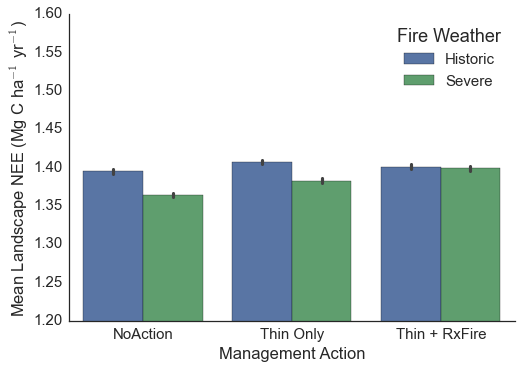

In [301]:
NEE_df = meanAnnualNEEs.groupby(['TRTMNT','WEATHER']).mean().reset_index()
sns.barplot(x = 'TRTMNT',y = 'NEE', hue = 'WEATHER', data = meanAnnualNEEs)
sns.despine()
plt.ylim([1.2, 1.6])
plt.ylabel('Mean Landscape NEE (Mg C ha$^{-1}$ yr$^{-1}$)')
plt.xlabel('Management Action')
plt.legend(title = 'Fire Weather')
plt.savefig('meanAnnualNEE.tif')


#### Frequency distributions
The differences we see above could be due to a few hugely different pixel values either due to some fluke of replication or a very localized treatment difference. Frequency distributions will help put my mind at ease -- although probabably won't look too different given the small differences in landscape NEE above.

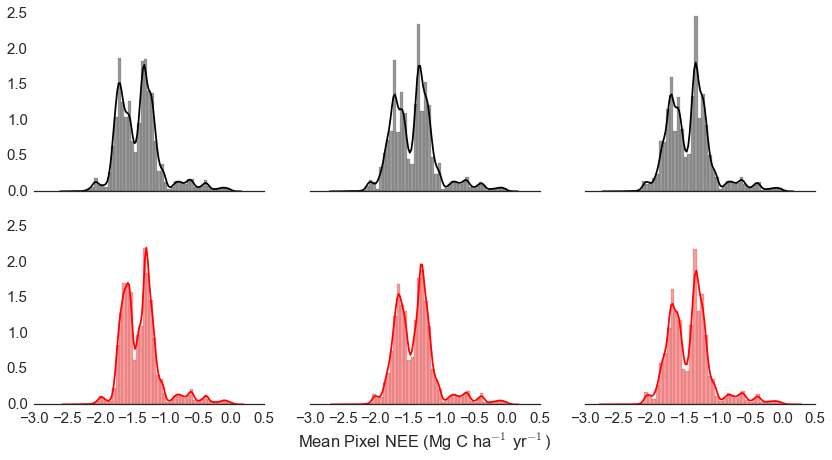

In [49]:
f, axes = plt.subplots(2, 3, figsize=(14,7), sharex=True, sharey=True)
sns.despine(left=True)

sns.distplot(meanAnnualNEEs1.NEE.dropna(), kde=True, color="k", ax=axes[0, 0])
sns.distplot(meanAnnualNEEs2.NEE.dropna(), kde=True, color="k", ax=axes[0, 1])
sns.distplot(meanAnnualNEEs3.NEE.dropna(), kde=True, color="k", ax=axes[0, 2])
sns.distplot(meanAnnualNEEs4.NEE.dropna(), kde=True, color="r", ax=axes[1, 0])
sns.distplot(meanAnnualNEEs5.NEE.dropna(), kde=True, color="r", ax=axes[1, 1])
sns.distplot(meanAnnualNEEs6.NEE.dropna(), kde=True, color="r", ax=axes[1, 2])

# Need to format all axes to remove labels
for ax in f.axes:
    ax.set_xlabel('')
axes[1, 1].set_xlabel('Mean Pixel NEE (Mg C ha$^{-1}$ yr$^{-1}$) ')
plt.savefig('MeanAnnualNEE_FrequencyDistributions.tif')

### Plot the NEE mapped data
Given the tiny landscape differences on average between management and fire weather severity, I don't expect to see any striking differences between the raw, non-differenced mapped output. So be it, lets plot it and take a look.

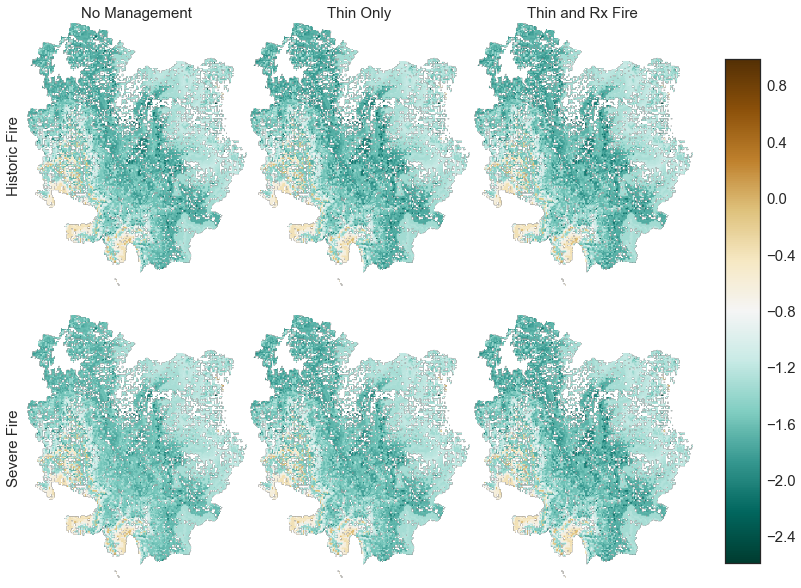

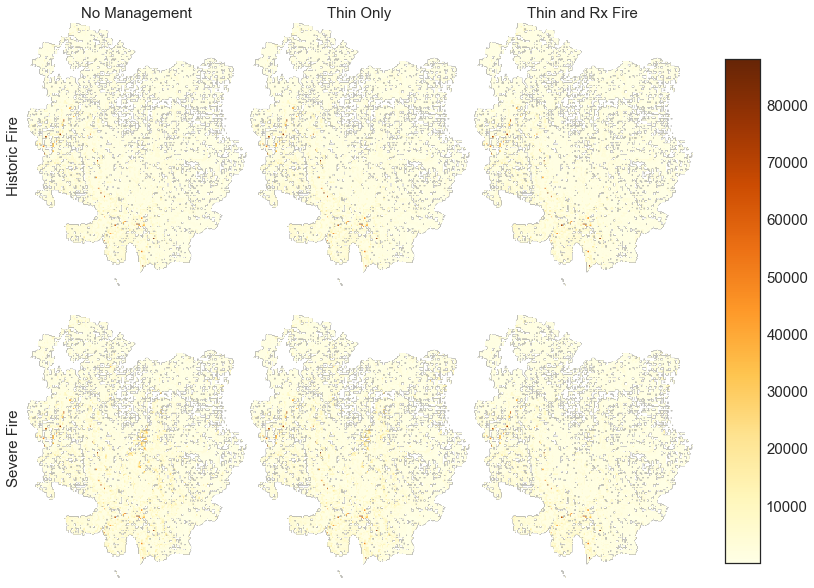

In [51]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(neeMapsLowP[0][simNamesV2[0]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax2.imshow(neeMapsLowP[2][simNamesV2[2]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax3.imshow(neeMapsLowP[4][simNamesV2[4]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax4.imshow(neeMapsLowP[1][simNamesV2[1]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
ax5.imshow(neeMapsLowP[3][simNamesV2[3]] / (50 * 100) * 0.01, cmap = 'BrBG_r', vmin = -2.575806, vmax = 1.00)
cbarmap = ax6.imshow(neeMapsLowP[5][simNamesV2[5]] / (50 * 100) * 0.01, cmap = 'BrBG_r', 
                     vmin = -2.575806, vmax = 1.00)
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
plt.savefig('cumulativeNEE_Dinkey.tif')

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(16,10))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(neeVarMapsLowP[0][simNamesV2[0]], cmap = 'YlOrBr')
ax2.imshow(neeVarMapsLowP[2][simNamesV2[2]], cmap = 'YlOrBr')
ax3.imshow(neeVarMapsLowP[4][simNamesV2[4]], cmap = 'YlOrBr')
ax4.imshow(neeVarMapsLowP[1][simNamesV2[1]], cmap = 'YlOrBr')
ax5.imshow(neeVarMapsLowP[3][simNamesV2[3]], cmap = 'YlOrBr')
cbarmap = ax6.imshow(neeVarMapsLowP[5][simNamesV2[5]], cmap = 'YlOrBr')
ax1.set_title('No Management', fontsize = 15)
ax2.set_title('Thin Only', fontsize = 15)
ax3.set_title('Thin and Rx Fire', fontsize = 15)
ax1.set_ylabel('Historic Fire', fontsize = 15)
ax4.set_ylabel('Severe Fire', fontsize = 15)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
sns.set_style('white')

### Relative Difference in NEE maps
Makes sense, there's really no difference. The varuiance between replicates is also pretty low --- but there are some areas where its a bit hotter. 

For now I want to look at how much more C is taken up (and where) in the treatment scenarios vs No Management scenarios, by fire weather condition.

In [53]:
## Historic 

ThinOnly_HistoricDiff = ((neeMapsLowP[2][simNamesV2[2]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

ThinRx_HistoricDiff = ((neeMapsLowP[4][simNamesV2[4]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

ThinOnly_SevereDiff = ((neeMapsLowP[3][simNamesV2[3]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100

ThinRx_SevereDiff = ((neeMapsLowP[5][simNamesV2[5]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100


SEVThinOnly_HistoricDiff = ((neeMapsLowP[2][simNamesV2[2]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

SEVThinRx_HistoricDiff = ((neeMapsLowP[4][simNamesV2[4]] - neeMapsLowP[0][simNamesV2[0]]) /\
    neeMapsLowP[0][simNamesV2[0]]) * 100

SEVThinOnly_SevereDiff = ((neeMapsLowP[3][simNamesV2[3]] - neeMapsLowP[1][simNamesV2[1]]) /\
    neeMapsLowP[1][simNamesV2[1]]) * 100

SEVThinRx_SevereDiff = ((sevMapsLowP[5][simNamesV2[5]] - sevMapsLowP[1][simNamesV2[1]]) /\
    sevMapsLowP[1][simNamesV2[1]]) * 100



print np.nansum(neeMapsLowP[0][simNamesV2[0]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[2][simNamesV2[2]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[4][simNamesV2[4]].ravel()) / (50 * 100) * 0.01 / 45256

print np.nansum(neeMapsLowP[1][simNamesV2[1]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[3][simNamesV2[3]].ravel()) / (50 * 100) * 0.01 / 45256
print np.nansum(neeMapsLowP[5][simNamesV2[5]].ravel()) / (50 * 100) * 0.01 / 45256

#ThinRx_SevereDiff[ThinRx_SevereDiff > 50] = 1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -50] = -1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -50] = -1


#ThinRx_SevereDiff[ThinRx_SevereDiff > 15] = 1
#ThinRx_SevereDiff[ThinRx_SevereDiff < -15] = -1

-1.39518132137
-1.40699528328
-1.40085880878
-1.36406912577
-1.38259167425
-1.39864271279


In [217]:
print np.nanmean(SEVThinOnly_HistoricDiff)
print np.nanmean(SEVThinRx_HistoricDiff)
print np.nanmean(SEVThinOnly_SevereDiff)
print np.nanmean(SEVThinRx_SevereDiff)

0.844478264203
0.479569076497
1.73289179328
-24.8807717525


In [56]:
thinrxsev = pd.DataFrame(dict(NEE_DIFF = ThinRx_SevereDiff.ravel(), TRTMNT = 'Thin + Rx Fire', 
                              WEATHER = 'Severe', SIM = 'ThinRxSevere'))
thinrxsev = thinrxsev.dropna()

thinrxhis = pd.DataFrame(dict(NEE_DIFF = ThinRx_HistoricDiff.ravel(), TRTMNT = 'Thin + Rx Fire', 
                              WEATHER = 'Historic', SIM = 'ThinRxHistoric'))
thinrxhis = thinrxhis.dropna()

thinsev = pd.DataFrame(dict(NEE_DIFF = ThinOnly_SevereDiff.ravel(), TRTMNT = 'Thin Only', 
                              WEATHER = 'Severe', SIM = 'ThinSevere'))
thinsev = thinsev.dropna()

thinhis = pd.DataFrame(dict(NEE_DIFF = ThinOnly_HistoricDiff.ravel(), TRTMNT = 'Thin Only', 
                              WEATHER = 'Historic', SIM = 'ThinHistoric'))
thinhis = thinhis.dropna()


trtmnt_diffs = pd.concat([thinrxsev,thinrxhis, thinsev, thinhis])
trtmnt_diffs.NEE_DIFF[(trtmnt_diffs.NEE_DIFF >  -5) & (trtmnt_diffs.NEE_DIFF <  5)] = np.nan

count = 0
for sim in np.unique(trtmnt_diffs.SIM):
    simsub = trtmnt_diffs[trtmnt_diffs.SIM == sim]
    if count == 0:
        capT = simsub[(simsub.NEE_DIFF < simsub.NEE_DIFF.quantile(.99)) & (simsub.NEE_DIFF > simsub.NEE_DIFF.quantile(.01))]
    else:
        cap = simsub[(simsub.NEE_DIFF < simsub.NEE_DIFF.quantile(.99)) & (simsub.NEE_DIFF > simsub.NEE_DIFF.quantile(.01))]
        capT = pd.concat([capT, cap])
    #print 'excluding data larger than ' + str(unitsub.Data.quantile(.99))
    count = count + 1

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### How many hectares experienced a 'large' difference in NEE because of treatment?
Lets look at just the pixels that experienced more than 15% change in their mean annual NEE values... either an increase or a decrease.

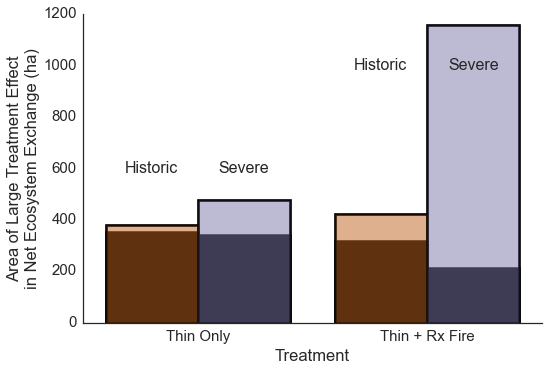

In [59]:
ha_Inc_CSink = capT[capT.NEE_DIFF > 15].groupby(['TRTMNT','WEATHER','SIM']).count().reset_index()
ha_Inc_CSink['DIR'] = 'Increase'
ha_Dec_CSink = capT[capT.NEE_DIFF < -15].groupby(['TRTMNT','WEATHER','SIM']).count().reset_index()
ha_Dec_CSink['DIR'] = 'Decrease'

CSink_ha = pd.concat([ha_Inc_CSink, ha_Dec_CSink])
legendEntries=[] 

ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", data=ha_Inc_CSink,            
                 linewidth=2.5, facecolor='white', order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
legendEntries.append(ax)
ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", data=ha_Dec_CSink,        
                 linewidth=2.5, facecolor='black', order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
ax = sns.barplot(x="TRTMNT", y="NEE_DIFF", hue="WEATHER", palette=['#d95f02','#7570b3'],data=ha_Inc_CSink,        
                 linewidth=2.5, alpha = 0.5, order = ['Thin Only','Thin + Rx Fire'],
                  errcolor=".2")
ax.legend('')
sns.despine()
sns.set_context('notebook',font_scale=1.5)
ax.set_ylabel('Area of Large Treatment Effect \nin Net Ecosystem Exchange (ha)')
ax.set_xlabel('Treatment')

ax.text(-.2, 600, "Historic", ha="center", va="center", size=16)
ax.text(0.2, 600, "Severe", ha="center", va="center", size=16)
ax.text(0.8, 1000, "Historic", ha="center", va="center", size=16)
ax.text(01.2, 1000, "Severe", ha="center", va="center", size=16)
plt.tight_layout()
plt.savefig('AreaChangeCSINK')

#### Not huge differences -- which we expected. Where do they fall out across the landscape?
Plotting some quick relative difference maps can help us place where these large differences are occurring on the landscape. Here, positive values indicate a percent increase in the mean (50 reps) cumulative (100 years) carbon uptake. 

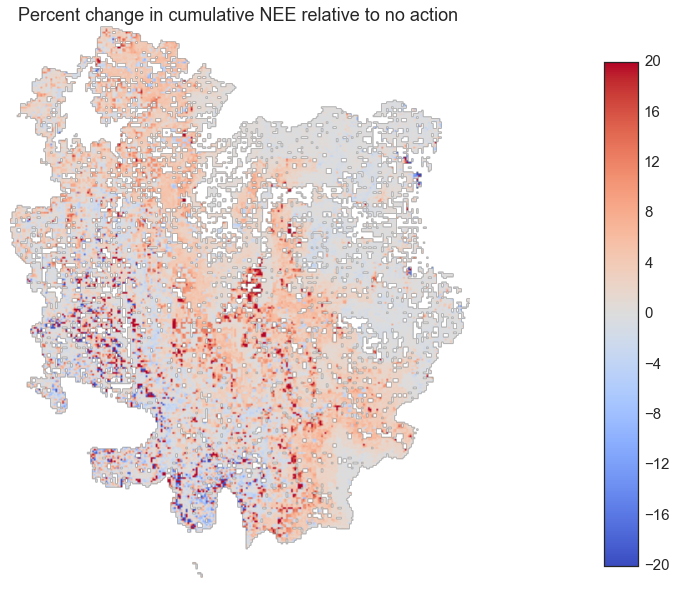

In [74]:
f, (ax1) = plt.subplots(1,1, figsize =(16,10))
plt.subplots_adjust(wspace = 0)
axs = f.axes
sns.despine(left=True, bottom=True)
ax1.set_yticklabels('')
ax1.set_xticklabels('')

cbarmap = ax1.imshow(ThinRx_SevereDiff, cmap = 'coolwarm', vmin = -20, vmax = 20)
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
ax1.set_title('Percent change in cumulative NEE relative to no action')
plt.savefig('PercentChange_NEE_Severe_ThinRx.tif')

#### We can do the same thing for fire severity
Here, negative values suggest decreases in mean fire severity relative to the No Action scenario.

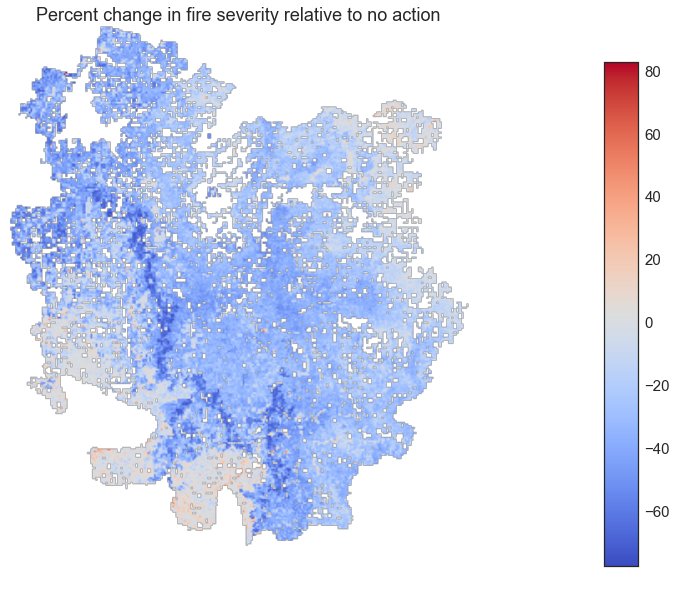

In [75]:
f, (ax1) = plt.subplots(1,1, figsize =(16,10))
plt.subplots_adjust(wspace = 0)
axs = f.axes
sns.despine(left=True, bottom=True)
ax1.set_yticklabels('')
ax1.set_xticklabels('')


cbarmap = ax1.imshow(SEVThinRx_SevereDiff, cmap = 'coolwarm')
cbar_ax = f.add_axes([0.83, 0.15, 0.03, 0.7])
f.colorbar(cbarmap, cax=cbar_ax)
ax1.set_title('Percent change in fire severity relative to no action')
plt.savefig('PercentChange_FSEV_Severe_ThinRx.tif')


### Drill into the LANDIS DFFS fire output to quantify wildfire emissions, and process stacks of thinned biomass to calculate emissions from RxFire
Normally we look at mean values per year of simulation across the 50 reps (e.g., for TEC or AGB). However, when we want to compare the end of run cumulative values for something, like in this case the cumulative emissions from wildfire, we've got to leverage another dataframe, that basically ignores the time stamps and generates a cumulative value for each column by replicate. We can then generate a distribution (boxplot, etc) of those cumulative values. 

I edited the genWeightedCentury function above to include this cumulative dataframe. Now we can integrate these data with the thin logs more easily as well.

In [231]:
import warnings # I know its bad practice ... 
warnings.filterwarnings('ignore')

totSums['SEV'] = 'NULL'
totSums.SEV[totSums.Sim == 'No Mgmt HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'Thinning HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'ThinningRx HWF'] = 'Historic'
totSums.SEV[totSums.Sim == 'No Mgmt SWF'] = 'Severe'
totSums.SEV[totSums.Sim == 'Thinning SWF'] = 'Severe'
totSums.SEV[totSums.Sim == 'ThinningRx SWF'] = 'Severe'

simsHistoric = totSums[totSums.SEV == 'Historic']
simsSevere = totSums[totSums.SEV == 'Severe']

warnings.filterwarnings('default')

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1        group2     meandiff  lower  upper  reject
----------------------------------------------------------
No Mgmt HWF   Thinning HWF  -0.2352  -0.7089 0.2385 False 
No Mgmt HWF  ThinningRx HWF -0.1014  -0.5751 0.3722 False 
Thinning HWF ThinningRx HWF  0.1337   -0.34  0.6074 False 
----------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1        group2     meandiff  lower    upper  reject
------------------------------------------------------------
No Mgmt SWF   Thinning SWF   0.7499  -11.0229 12.5226 False 
No Mgmt SWF  ThinningRx SWF -16.2141 -27.9868 -4.4414  True 
Thinning SWF ThinningRx SWF -16.964  -28.7367 -5.1913  True 
------------------------------------------------------------


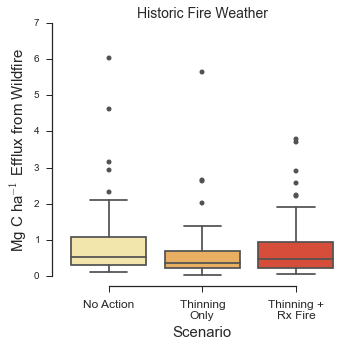

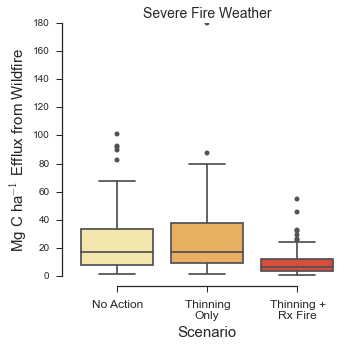

In [232]:
flierprops = dict(marker='o', markersize=5)

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'FireCEffluxw', data = simsHistoric, 
                  palette=EcoregionFC, flierprops = flierprops)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Historic.tif')

f = plt.figure(figsize=(5,5))
fig = sns.boxplot(x = 'Sim', y = 'FireCEffluxw', data = simsSevere, 
                  palette=EcoregionFC, flierprops = flierprops)
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Severe.tif')


print pairwise_tukeyhsd(simsHistoric.dropna()['FireCEffluxw'], simsHistoric.dropna()['Sim'])
print pairwise_tukeyhsd(simsSevere.dropna()['FireCEffluxw'], simsSevere.dropna()['Sim'])



#### Same figures as above, but with bars instead of boxes
I dont like it as much, but I should be able to more easily display the fraction of fire emissions
that are due to Rx fire.


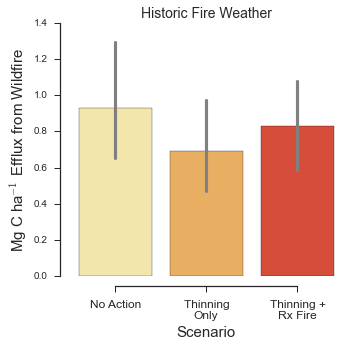

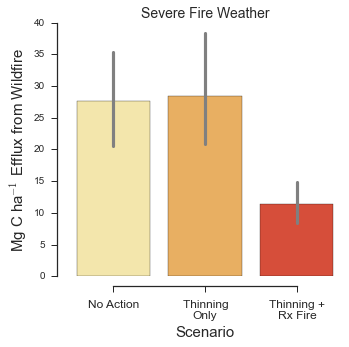

In [233]:
f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsHistoric, 
                  palette=EcoregionFC, errcolor = 'gray')
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Historic_bar.tif')

f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'FireCEffluxw', data = simsSevere, 
                  palette=EcoregionFC, errcolor = 'gray')
sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('WildfireEmissions_Severe_bar.tif')

### Histograms and Surface KDEs of mean fire severity from the DFFS fire log
These really just get at the mean severity, which is sort of normalized to some degree with fire size.. given that the larger the fire, the lower the mean will tend to be. If we want to capture the amount of torching, or describe how 'mixed' the severity of a fire is, we will have to dive fully into the fire rasters, which would take some time to loop through -- Certainly an exercise for another day ...

In [80]:
fireLoc = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
dffsLog = 'dynamic-fire-test-log.csv'

counter = 0
for simname in simNamesV2:
    num_replicates = len(next(os.walk(fireLoc + simname))[1])
    reps = np.arange(1,num_replicates+1,1)
    for rep in reps:
        wkDir_c = fireLoc + simname + '/replicate' + str(rep) + '/'
        if counter == 0:
            flogTot = pd.read_csv(wkDir_c + dffsLog)
            flogTot['SIM'] = simname
            flogTot['REP'] = rep
        else:           
            flog = pd.read_csv(wkDir_c + dffsLog)
            flog['SIM'] = simname
            flog['REP'] = rep
            flogTot = pd.concat([flogTot, flog])
        counter = counter + 1

flogTot[flogTot.TotalSitesInEvent <= 0].TotalSitesInEvent = np.nan
flogTot = flogTot.dropna()

#### Clean up and append some treatment labels to the data

In [81]:
warnings.filterwarnings('ignore')

flogTot['SEV'] = 'Null'
flogTot['TRTMNT'] = 'Null'

flogTot.SEV[flogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'No Action'

flogTot.SEV[flogTot.SIM == 'ThinHistoric_FV2'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'ThinHistoric_FV2'] = 'Thinning Only'

flogTot.SEV[flogTot.SIM == 'ThinRxHistoric_FV2'] = 'Historic'
flogTot.TRTMNT[flogTot.SIM == 'ThinRxHistoric_FV2'] = 'Thinning + Rx Fire'

flogTot.SEV[flogTot.SIM == 'NoMgmtSevereFireLowP'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'NoMgmtSevereFireLowP'] = 'No Action'

flogTot.SEV[flogTot.SIM == 'ThinSevere_FV2'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'ThinSevere_FV2'] = 'Thinning Only'

flogTot.SEV[flogTot.SIM == 'ThinRxSevere_FV2'] = 'Severe'
flogTot.TRTMNT[flogTot.SIM == 'ThinRxSevere_FV2'] = 'Thinning + Rx Fire'


flogTot[flogTot.TotalSitesInEvent == 0] = np.nan

warnings.filterwarnings('default')

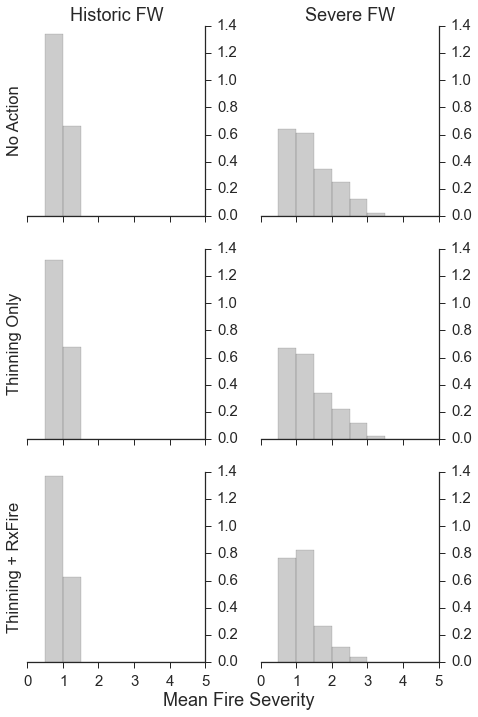

In [87]:
# Set up the  figure
sns.set_context('notebook', font_scale=1.5)
f, axes = plt.subplots(3, 2, figsize=(7, 10), sharex=True, sharey = True)
subplots_adjust(hspace = 0.20, wspace = 0.4)
axs = f.axes
idx = 0

for sim in simNamesV2:
    ax = axs[idx]
    toplot = flogTot[flogTot.SIM == sim]
    sns.distplot(toplot.MeanSeverity, kde=False, color="gray", 
                 bins=np.linspace(0,5,11),norm_hist = True, ax=ax)
    ax.set_xlabel('')
    # Setup the facet and axes labels
    if idx == 0:
        ax.set_title('Historic FW')
        ax.set_ylabel('No Action')
        
    if idx == 1:
        ax.set_title('Severe FW')

    if idx == 2:
        ax.set_ylabel('Thinning Only')
        
    if idx == 4:
        ax.set_ylabel('Thinning + RxFire')
        
    idx = idx + 1

# Create joint X label
f.text(0.5, 0.01, 'Mean Fire Severity', ha='center', va='center')

#plt.tight_layout()
sns.set_style('ticks')
sns.despine(left = True, right = False)
plt.tight_layout()
plt.savefig('FireSize_Dist.tif')

#### We need a similar figure, but to capture the fire size distributions from our simulations
Same approach, since we have fire size data in the fire logs.

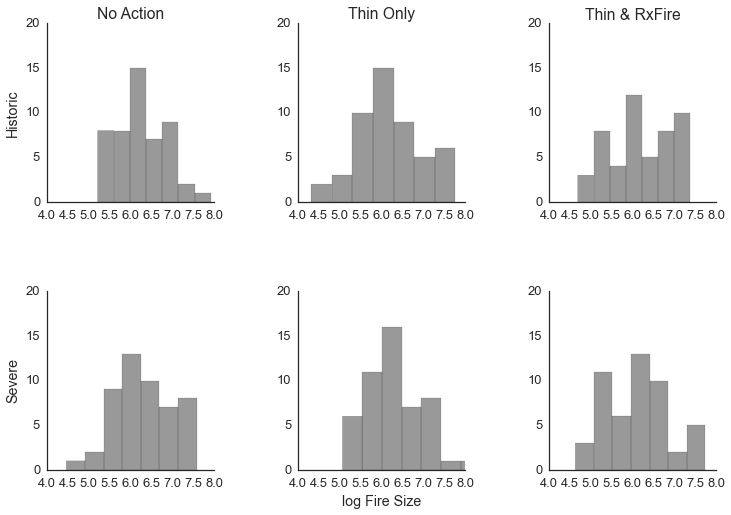

In [314]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(12,8))
axs = f.axes
idx = 0
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for sim in simNamesV2:
    if idx == 0:
        ax = axs[idx]
        ax.set_ylabel('Historic')
        ax.set_title('No Action')
    elif idx == 1:
        ax = axs[3]
        ax.set_ylabel('Severe')
        ax.set_title('')
    elif idx == 2:
        ax = axs[1]
        ax.set_title('Thin Only')
    elif idx == 3:
        ax = axs[4]
    elif idx == 4:
        ax = axs[2]
        ax.set_title('Thin & RxFire')

    else:
        ax = axs[5]

    simsub = flogTot[flogTot.SIM == sim]
    simsreps = simsub.groupby('REP').mean().reset_index()
    sns.distplot(np.log(simsreps.TotalSitesInEvent), 
                 hist = True, kde = False, color = 'k', bins = 7, ax = ax)

    ax.set_xlim([4,8])
    ax.set_ylim([0,20])
    numFires = simsreps.count()
    if idx == 3:
        ax.set_xlabel('log Fire Size')
    else:
        ax.set_xlabel('')
    idx = idx + 1
sns.despine()
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white')
plt.savefig('FireSizeHIST.tiff')


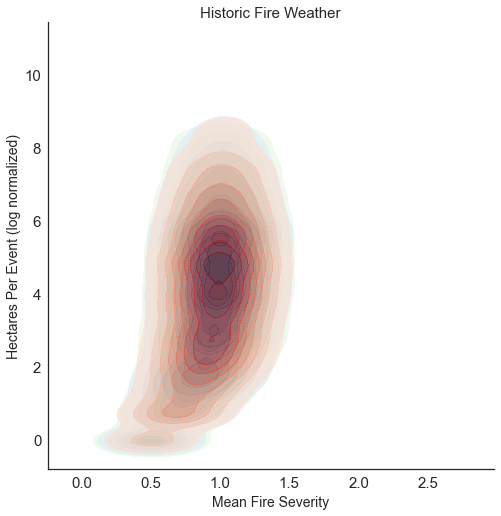

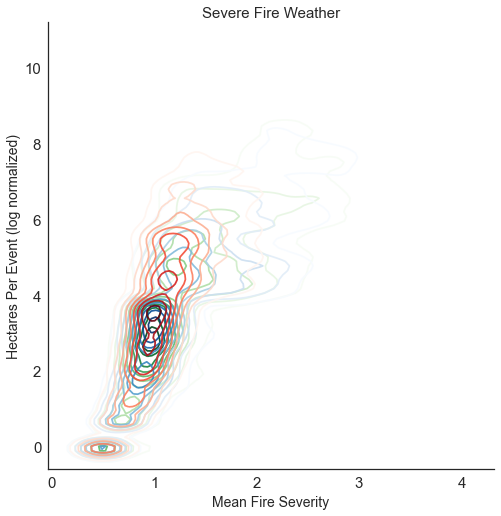

In [132]:
# Set up the figure -- Basically slapping three KDEs (one per sim) 
# on each fig panel, with each panel representing fire weather severity
f, ax = plt.subplots(figsize=(8, 8))

#ax.set_aspect("equal")
thismap = ['Greens','Blues','Reds']

idx = 0
for SIMNAME in ['NoMgmtHistoricFireLowP','ThinHistoric_FV2', 'ThinRxHistoric_FV2']:
    toPlot = flogTot[flogTot.SIM == SIMNAME]
    ax = sns.kdeplot(toPlot.MeanSeverity, np.log(toPlot.TotalSitesInEvent),
                     cmap=thismap[idx], shade=True, shade_lowest=False,bw = .25, alpha = 0.5)
    idx = idx + 1
ax.set_title('Historic Fire Weather', fontsize = 15)
ax.set_xlabel('Mean Fire Severity', fontsize = 14)
ax.set_ylabel('Hectares Per Event (log normalized)', fontsize = 14)
sns.set_context('notebook', font_scale=1.5)
sns.despine()
plt.savefig('FireSize_Hist_KDE.tif')

f, ax = plt.subplots(figsize=(8, 8))
idx = 0   
for SIMNAME in ['NoMgmtSevereFireLowP','ThinSevere_FV2', 'ThinRxSevere_FV2']:
    toPlot = flogTot[flogTot.SIM == SIMNAME]
    ax = sns.kdeplot(toPlot.MeanSeverity, np.log(toPlot.TotalSitesInEvent),
                     cmap=thismap[idx], shade=False, shade_lowest=False, bw = .18, alpha = .9)
    idx = idx + 1
ax.set_title('Severe Fire Weather', fontsize = 15)
ax.set_xlabel('Mean Fire Severity', fontsize = 14)
ax.set_ylabel('Hectares Per Event (log normalized)', fontsize = 14)
sns.set_context('notebook', font_scale=1.5)
sns.despine()
plt.savefig('FireSize_Sev_KDE.tif')


### How much biomass was removed during mechanical thinning, and volatalized during Rx Fire? 
To answer those questions we need to drill into the thin logs. Lets start by making a data frame that contains summary info for each weather and treatment permutation, maybe wrap it into a function for furture LANDIS work, since thats baller.

In [143]:
### ***** This is a time consuming step ***** ###

thinLoc = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
thinLog = 'log.csv'

# We only want (can) look at the thin logs for the managed scenarios
simsManaged = ['ThinHistoric_FV2', 'ThinSevere_FV2',
            'ThinRxHistoric_FV2','ThinRxSevere_FV2']

counter = 0
for simname in simsManaged:
    num_replicates = len(next(os.walk(fireLoc + simname))[1])
    reps = np.arange(1,num_replicates+1,1)
    for rep in reps:
        wkDir_c = thinLoc + simname + '/replicate' + str(rep) + '/Thin/'
        if counter == 0:
            tlogTot = pd.read_csv(wkDir_c + thinLog)
            tlogTot['SIM'] = simname
            tlogTot['REP'] = rep
        else:           
            tlog = pd.read_csv(wkDir_c + thinLog)
            tlog['SIM'] = simname
            tlog['REP'] = rep
            tlogTot = pd.concat([tlogTot, tlog])
        counter = counter + 1



In [144]:
warnings.filterwarnings('ignore')

tlogTot['SEV'] = 'Null'
tlogTot['TRTMNT'] = 'Null'

tlogTot.SEV[tlogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'NoMgmtHistoricFireLowP'] = 'No Action'

tlogTot.SEV[tlogTot.SIM == 'ThinHistoric_FV2'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinHistoric_FV2'] = 'Thinning Only'

tlogTot.SEV[tlogTot.SIM == 'ThinRxHistoric_FV2'] = 'Historic'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinRxHistoric_FV2'] = 'Thinning + Rx Fire'

tlogTot.SEV[tlogTot.SIM == 'NoMgmtSevereFireLowP'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'NoMgmtSevereFireLowP'] = 'No Action'

tlogTot.SEV[tlogTot.SIM == 'ThinSevere_FV2'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinSevere_FV2'] = 'Thinning Only'

tlogTot.SEV[tlogTot.SIM == 'ThinRxSevere_FV2'] = 'Severe'
tlogTot.TRTMNT[tlogTot.SIM == 'ThinRxSevere_FV2'] = 'Thinning + Rx Fire'


warnings.filterwarnings('default')

#### Now that we have the thin log data
stored as one giant dataframe, we need to take sums by treatment/weather across reps. The goal here will be to calculate the mean of the 50 sums (reps) within treatments, so we can report a mean and variance of the biomass removed (or volatized) per treatment/weather combo

In [296]:
groupedTlog = tlogTot.groupby(['SIM','Prescription','REP']).sum()
thinByRep = groupedTlog.reset_index()

thinMean = thinByRep.groupby(['SIM','Prescription','SEV','TRTMNT']).mean().reset_index()
thinStd = thinByRep.groupby(['SIM','Prescription','SEV','TRTMNT']).std().reset_index()

#thinSumMGMT = tlogTot.groupby(['SIM','ManagementArea','Prescription','SEV','TRTMNT','REP']).sum().reset_index()
thinMEANMGMT = tlogTot.groupby(['SIM','ManagementArea','Prescription','SEV','TRTMNT','REP']).mean().reset_index()

# Normalize the Biomass Removed by the total area of the simulation (active grid cells), 
# and turn AGB into C. This will make our management C numbers mesh well with the Wildfire C emissions
# from the century output
thinMean['activeArea'] = 45256
thinByRep['activeArea'] = 45256

thinMean['AreaWeightedC_Reduc'] = (thinMean.MgBiomassRemoved / thinMean['activeArea'])*.5
thinByRep['AreaWeightedC_Reduc'] = (thinByRep.MgBiomassRemoved / thinByRep['activeArea'])*.5


#### Finally we can create some summary figures 
that look at how biomass was removed across the simulations. I need to calculate the area of each management unit, in order to calculate the per hectare biomass removed, per management unit.

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


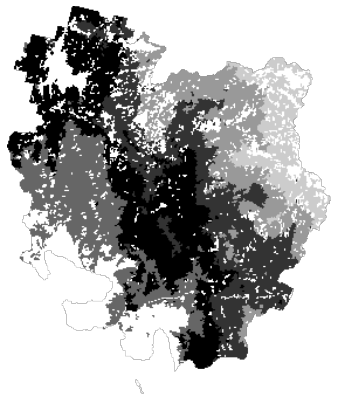

In [297]:
# First lets just import the management unit raster and count the number of cells (ha) in each mgmt unit.
# Read in the raster
mgmtUnit = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/MgmtRedux.tif'
src_ds = gdal.Open( mgmtUnit )
mgmtmap = src_ds.ReadAsArray()
mgmtmap = mgmtmap.astype('float')
mgmtmap[mgmtmap == 0] = np.nan
masked_bio = np.ma.array (mgmtmap, mask=(np.isnan(mgmtmap)))  

# Create the figure and show the image
f, (ax) = plt.subplots(1,1, figsize =(7,7))
axmap = ax.imshow(mgmtmap, cmap = 'gray')

# Axis label formatting, and seaborn despining
ax.set_yticklabels('')
ax.set_xticklabels('')
sns.despine(left=True, bottom=True)
sns.set_style('white')

# Create a dummy variable, tehn fill it with the respective areas of each management unit
thinMeanMGMT['mgmtArea'] = 0
for mgmt in [1,2,3,4]:
    thinMeanMGMT.mgmtArea[thinMeanMGMT.ManagementArea == mgmt] = len(mgmtmap[mgmtmap == mgmt])

# Now calculate the respective area weighted C reduction
thinMeanMGMT['AreaWeightedC_Reduc'] = (thinMeanMGMT.MgBiomassRemoved / thinMeanMGMT['mgmtArea'])*.5


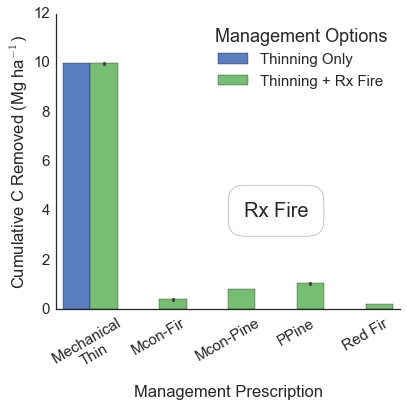

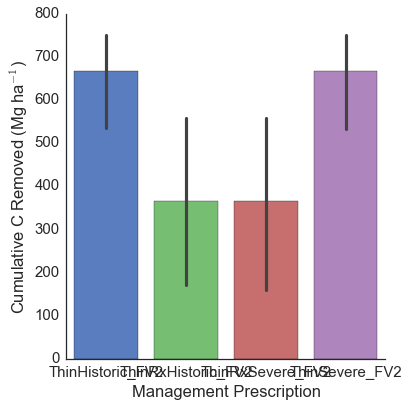

In [302]:
g = sns.factorplot(x="Prescription", y='AreaWeightedC_Reduc',
                   hue = 'TRTMNT', data=thinByRep,
                   size=6, kind="bar", palette="muted", legend = False)
g.set_xticklabels(['Mechanical \nThin','Mcon-Fir','Mcon-Pine','PPine','Red Fir'], rotation = 30)

RxFireProp = dict(boxstyle="round, pad =0.8", fc="w", ec="black", alpha=0.7)
plt.text(2.7, 4, "Rx Fire", ha="center", va="center", size=20,
        bbox=RxFireProp)

g.set_xlabels('Management Prescription')
g.set_ylabels('Cumulative C Removed (Mg ha$^{-1}$)')
g.set_titles('End of Simulation C Reductions')
plt.legend(title = 'Management Options')
sns.set_context('notebook', font_scale=1.5)
plt.tight_layout()

sns.set_context('notebook', font_scale=1.5)
plt.savefig('CarbonRemoved_Mgmt.tif')

g = sns.factorplot(x="SIM", y='AreaWeightedC_Reduc',data=thinMeanMGMT,
                   size=6, kind="bar", palette="muted", legend = False)

g.set_xlabels('Management Prescription')
g.set_ylabels('Cumulative C Removed (Mg ha$^{-1}$)')
g.set_titles('End of Simulation C Reductions')
plt.legend(title = 'Management Options')
sns.set_context('notebook', font_scale=1.5)
plt.tight_layout()

sns.set_context('notebook', font_scale=1.5)
plt.savefig('CarbonRemoved_MgmtSep.tif')



#### Finally, a quick calculation of the cumulative Mg C removed by Rx Fire
because these numbers probably don't vary much from run to run, I 
could just stop there... but the paranoia started to set in. Lets also 
take the data grouped by replicate, and make sure.

In [236]:
# These are basically the mean emissions across replicates
RxEmissionsH = thinMean[(thinMean.Prescription != 'ThinOnly') & \
                        (thinMean.SEV == 'Historic')].AreaWeightedC_Reduc.sum()
RxEmissionsS = thinMean[(thinMean.Prescription != 'ThinOnly') & \
                        (thinMean.SEV == 'Severe')].AreaWeightedC_Reduc.sum()
print RxEmissionsH
print RxEmissionsS

allRxEmissionsH = thinByRep[(thinByRep.Prescription != 'ThinOnly') & \
                        (thinByRep.SEV == 'Historic')].groupby('REP').sum().reset_index()

allRxEmissionsS = thinByRep[(thinByRep.Prescription != 'ThinOnly') & \
                        (thinByRep.SEV == 'Severe')].groupby('REP').sum().reset_index()

# Now we have to add these values to the FireEfflux(adjusted) values for the Thin + Rx Fire simulations
simsHistoric['RxAdjustedEmissions'] = simsHistoric.FireCEffluxw 
simsSevere['RxAdjustedEmissions'] = simsSevere.FireCEffluxw 

simsHistoric['propOfWF'] = 0 
simsSevere['propOfWF'] = 0

simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF'] = \
    simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF'] + allRxEmissionsH.AreaWeightedC_Reduc
simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF'] = \
    simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF'] + allRxEmissionsS.AreaWeightedC_Reduc

# What is the proportion of the fire emissions of C that is due to management?
simsHistoric.propOfWF[simsHistoric.Sim == 'ThinningRx HWF'] = \
    allRxEmissionsH.AreaWeightedC_Reduc / simsHistoric.RxAdjustedEmissions[simsHistoric.Sim == 'ThinningRx HWF']
simsSevere.propOfWF[simsSevere.Sim == 'ThinningRx SWF'] = \
    allRxEmissionsS.AreaWeightedC_Reduc / simsSevere.RxAdjustedEmissions[simsSevere.Sim == 'ThinningRx SWF']
    
simsHistoric['RxOnly'] = 0
simsSevere['RxOnly'] = 0 
simsHistoric.RxOnly[simsHistoric.Sim == 'ThinningRx HWF'] = allRxEmissionsH.AreaWeightedC_Reduc
simsSevere.RxOnly[simsSevere.Sim == 'ThinningRx SWF'] = allRxEmissionsS.AreaWeightedC_Reduc


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\A

2.44236298612
2.47611148577


#### Now revisit the bar plots from before, but adding in the above Rx Fire C emissions

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1        group2     meandiff lower  upper  reject
---------------------------------------------------------
No Mgmt HWF   Thinning HWF  -0.2352  -0.701 0.2307 False 
No Mgmt HWF  ThinningRx HWF  2.3409  1.8751 2.8068  True 
Thinning HWF ThinningRx HWF  2.5761  2.1102 3.0419  True 
---------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1        group2     meandiff  lower    upper  reject
------------------------------------------------------------
No Mgmt SWF   Thinning SWF   0.7499  -11.0199 12.5196 False 
No Mgmt SWF  ThinningRx SWF -13.738  -25.5077 -1.9683  True 
Thinning SWF ThinningRx SWF -14.4879 -26.2576 -2.7182  True 
------------------------------------------------------------


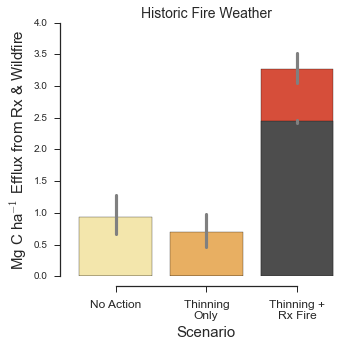

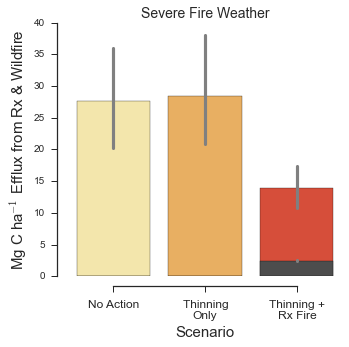

In [237]:
f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'RxAdjustedEmissions', data = simsHistoric, 
                  palette=EcoregionFC, errcolor = 'gray')
fig = sns.barplot(x = 'Sim', y = 'RxOnly', data = simsHistoric, 
                  facecolor = "0.3", errcolor = 'gray')

sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Rx & Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Historic Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('Wildfire_Rx_Emissions_Historic_bar.tif')

f = plt.figure(figsize=(5,5))
fig = sns.barplot(x = 'Sim', y = 'RxAdjustedEmissions', data = simsSevere, 
                  palette=EcoregionFC, errcolor = 'gray')
fig = sns.barplot(x = 'Sim', y = 'RxOnly', data = simsSevere, 
                  facecolor = "0.3", errcolor = 'gray')

sns.set_context('notebook')
axes = fig.axes
axes.set_xlabel('Scenario', fontsize = 15)
axes.set_ylabel('Mg C ha$^{-1}$ Efflux from Rx & Wildfire', fontsize = 15)
sns.despine(offset=10, trim=True)
axes.set_xticklabels(['No Action', 'Thinning \nOnly','Thinning + \nRx Fire'])
plt.xticks(rotation=0, fontsize = 12)
plt.title('Severe Fire Weather', fontsize = 14)
plt.tight_layout()
plt.savefig('Wildfire_Rx_Emissions_Severe_bar.tif')

print pairwise_tukeyhsd(simsHistoric.dropna()['RxAdjustedEmissions'], simsHistoric.dropna()['Sim'])
print pairwise_tukeyhsd(simsSevere.dropna()['RxAdjustedEmissions'], simsSevere.dropna()['Sim'])


In [208]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
import matplotlib.patches as patches

m = Basemap(llcrnrlon=-121.7,llcrnrlat=34.4,urcrnrlon=-114.5,urcrnrlat=40.5,
             resolution='i', projection='tmerc', lat_0 = 37.1, lon_0 = -119.3, ax = ax)


# Specify the name of our vector
mgmt = 'mgmtUnit_5070.shp'

mgmtUnits = gpd.GeoDataFrame.from_file(wrkdir + mgmt)
mgmtUnits_crs = mgmtUnits.crs
summedNEE = 'NEEmapS.tif'

metrics = "min max mean median std range".split()
stats = zonal_stats(wrkdir + mgmt, wrkdir + summedNEE, stats=metrics, nodata = -9999)

df = pd.DataFrame(stats)
df.head()
sim = 'SevereWFxThinRx'
new_colnames = ["{}_{}".format(sim, metric) for metric in metrics]
df2 = df.rename(columns=dict(zip(metrics, new_colnames)))
df2.head()
df3 = mgmtUnits.join(df2)
df3.head()

df3.__class__ = gpd.GeoDataFrame
df3.crs = mgmtUnits.crs
df3.set_geometry('geometry')

df3.head()
df3.SevereWFxThinRx_mean = df3.SevereWFxThinRx_mean * 100

In [ ]:
plot_dataframe(df3, column='SevereWFxThinRx_mean', scheme='Quantiles', 
                    k=6, colormap='RdBu', 
                    legend = True, linewidth = 0.2)
plt.title('Mean % Increase in Cumulative NEE')
sns.despine()
plt.savefig('CumulativeNEE_PercentIncrease.tif', dpi = 300)

In [ ]:
# pull out the pixels in each of the six management areas, each into a separate dataframe,
# then concatenate them for plotting


dataraster = gdal.Open(wrkdir + 'NEEmapS.tif').ReadAsArray()
templateraster = gdal.Open(wrkdir + 'MgmtRedux.tif').ReadAsArray()
sim = 'SevereTxRx'
dataraster[dataraster == -9999] = np.nan
count = 0

for ID in np.unique(templateraster):
    ID_data = dataraster[templateraster == ID]
    if count == 0:
        zonalData = pd.DataFrame(dict(Data = ID_data))
        zonalData['Unit'] = ID
        zonalData['Sim'] = sim
    else:
        toAppend = pd.DataFrame(dict(Data = ID_data))
        toAppend['Unit'] = ID
        toAppend['Sim'] = sim

        zonalData = pd.concat([zonalData, toAppend])
    count = count + 1
    
dataraster = gdal.Open(wrkdir + 'NEEmapH.tif').ReadAsArray()
templateraster = gdal.Open(wrkdir + 'MgmtRedux.tif').ReadAsArray()
sim = 'HistoricTxRx'
dataraster[dataraster == -9999] = np.nan
count = 0

for ID in np.unique(templateraster):
    ID_data = dataraster[templateraster == ID]
    if count == 0:
        zonalDataH = pd.DataFrame(dict(Data = ID_data))
        zonalDataH['Unit'] = ID
        zonalDataH['Sim'] = sim
    else:
        toAppend = pd.DataFrame(dict(Data = ID_data))
        toAppend['Unit'] = ID
        toAppend['Sim'] = sim

        zonalDataH = pd.concat([zonalDataH, toAppend])
    count = count + 1

zonalDataH = zonalDataH.dropna()
zonalData = zonalData.dropna()

zonalDataT = pd.concat([zonalData, zonalDataH])
#zonalDataT[zonalDataT.Data > 1] = np.nan
#zonalDataT[zonalDataT.Data < -1] = np.nan
zonalDataT[zonalDataT.Unit == 0] = np.nan
zonalDataT.Data = zonalDataT.Data / 100

### Filter the data by management unit to exclude the 99th and 1st percentile data
Because we are using KDE's to plot split violin plots, outliers really mess with the way the density estimates are drawn. We don't have to remove many points to get nice looking figures. Here, we call outliers any datapoint that falls outside the 99th percentile of data.

In [ ]:
count = 0
for unit in np.unique(zonalDataT.Unit):
    unitsub = zonalDataT[zonalDataT.Unit == unit]
    if count == 0:
        capT = unitsub[(unitsub.Data < unitsub.Data.quantile(.99)) & (unitsub.Data > unitsub.Data.quantile(.01))]
    else:
        cap = unitsub[(unitsub.Data < unitsub.Data.quantile(.99)) & (unitsub.Data > unitsub.Data.quantile(.01))]
        capT = pd.concat([capT, cap])
    #print 'excluding data larger than ' + str(unitsub.Data.quantile(.99))
    count = count + 1

In [ ]:
burnSevColors = ["#fdae6b","#9ecae1"]
burnSev = sns.color_palette(burnSevColors)

f, (ax1) = plt.subplots(1, figsize = (15, 7))

mgmtViolin = sns.violinplot(x="Unit", y="Data", hue="Sim",
                     data=capT, palette=sns.color_palette(burnSevColors),
                     split=True, scale = 'count', 
                     inner="quartile", bw = 0.06,
                     ax = ax1)
sns.despine()
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
ax1.set_xlabel('Management Unit')
ax1.set_xticklabels(['MCON-Pine', 'MCON-Fir', 
                     'Ponderosa','Red Fir',
                     'Subapline','NoTreatment'],
                    rotation = 35)
ax1.set_ylabel('Difference in Cumulative C uptake \n Due to Management (Mg C ha$^{-1}$)')
ax1.legend(loc = 2)

bbox_props = dict(boxstyle="round, pad =0.6", fc="w", ec="black", alpha=0.7)
ax1.text(4.5, 17, "Untreated Areas", ha="center", va="center", size=20,
        bbox=bbox_props)

ax1.text(3, 17, "Rx Fire Only", ha="center", va="center", size=20,
        bbox=bbox_props)
plt.savefig('NEE_Diff_NM-ThRx_His_Sev.tif', dpi = 300)